In [99]:
import pandas as pd
import requests
from Bio import SeqIO
import numpy as np
import gemmi as gm
from utils import read_GEMME_mat, alph, bfactorsPDB, ResidueSensitivityGEMME
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
from matplotlib_venn import venn3, venn2
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, auc 
import itertools as it
from itertools import combinations
import re
import pickle

In [549]:
WORK_DIR = os.path.dirname(os.path.abspath('')) + os.sep
## representative proteoforms per gene for 6.44 FlyBase proteome version
df_Isoforms = pd.read_csv(f'{WORK_DIR}/csv/'+'dmel_unique_protein_isoforms_fb_2022_01.tsv', skiprows=5, skipfooter=1, engine='python', names=['FBgn_ID', 'gene_symbol', 'representative_proteoform', 'identical_protein'], sep='\t')

## dataframe with prediction data information
df_Dmel_recap = pd.read_csv(f'{WORK_DIR}/csv/'+'Dmel6.44PredictionsRecap.csv', index_col=0)
df_Dmel_recap_Conf = df_Dmel_recap.loc[(df_Dmel_recap['GEMME_GlobalConfidence']==True)&(df_Dmel_recap['Representative_FBpp']==True)].copy() 

## dictionnary with protein sequences
dc_protein_seqs = SeqIO.to_dict(SeqIO.parse(f'{WORK_DIR}/csv/'+'dmel-all-translation-r6.44.fasta', "fasta"))  

## GEMME local confidence 
df_Confidence = pd.read_csv(f'{WORK_DIR}/csv/ConfidenceLocal_pLDDT.csv', index_col=0)
df_Confidence['NonConf_Residues'] = df_Confidence['NonConf_Residues'].apply(lambda x: eval(x) if pd.notna(x) else None)
df_Confidence['NonConf_Intervals'] = df_Confidence['NonConf_Intervals'].apply(lambda x: eval(x) if pd.notna(x) else None)

## PTM data
df_PTM_proteome = pd.read_csv(f'{WORK_DIR}/csv/PTM.csv')
df_PTM_proteome_Conf = df_PTM_proteome.loc[df_PTM_proteome['FBpp_ID'].isin(df_Dmel_recap.loc[df_Dmel_recap['GEMME_GlobalConfidence']==True].index.tolist())].copy()

## Number of SNPs per gene
df_nbSNPperGENE = pd.read_csv(f'{WORK_DIR}/csv/'+'DGRP_nbSNPperGENE.csv', index_col=0)

## Physical interactions per gene
df_Interaction = pd.read_csv(f'{WORK_DIR}/csv/'+'Interactions_GenPhys.csv', index_col=0)

df_mapping = pd.read_csv(f'{WORK_DIR}/csv/mapping_database.csv', index_col=0)
df_ProteoCast_Benchmark = pd.read_csv(f'{WORK_DIR}/csv/'+'ProteoCast_Benchmark.csv')

how does this align to the following statement? "Among these, 223 sequences have very poor multiple sequence alignments (MSAs), with a median of only 8 sequences per alignment. Notably, 8 of these proteoforms are shorter than 21 amino acids, the minimum required length for GEMME analysis."

In [523]:
# Path to the FASTA file
fasta_file = list(SeqIO.parse('/Users/manchuta/Desktop/proteome_batch_6.fasta', 'fasta'))
total_length = 0
for seq in fasta_file:
    total_length += len(seq.seq)
print('total length of 300 sequences', total_length)

total length of 300 sequences 1185789


## Table S1

In [13]:
## with a structure and predictions
df_Confidence_Struct = df_Confidence.loc[df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True)&(~df_Dmel_recap['Structure_3D_file'].isnull())].index].copy()
print('with 3D', df_Confidence_Struct.shape)
df_Confidence_Struct = df_Confidence.loc[df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap['GEMME_prediction']==True)&(~df_Dmel_recap['Structure_3D_file'].isnull())].index].copy()
print('and GEMME predictions', df_Confidence_Struct.shape)
## high global confidence 
df_Conf_Represen_Struct_Conf = df_Confidence_Struct.loc[df_Confidence_Struct['GEMME_GlobalConfidence']==True].copy()
print('Confident pedictions', df_Conf_Represen_Struct_Conf.shape)

print('Number of confident residues in the proteome ', df_Confidence.loc[df_Confidence['GEMME_GlobalConfidence']==True, 'Length'].sum() - df_Confidence.loc[df_Confidence['GEMME_GlobalConfidence']==True, 'Num_NonConf_Res'].sum(), 
        'which represents ',round((df_Confidence.loc[df_Confidence['GEMME_GlobalConfidence']==True, 'Length'].sum() - df_Confidence.loc[df_Confidence['GEMME_GlobalConfidence']==True, 'Num_NonConf_Res'].sum())/ df_Confidence.loc[df_Confidence['GEMME_GlobalConfidence']==True, 'Length'].sum()*100, 3), '%')
print('Number of confident residues with a 3D structure ', df_Conf_Represen_Struct_Conf['Length'].sum() - df_Conf_Represen_Struct_Conf['Num_NonConf_Res'].sum(), 'which represents ', round(( df_Conf_Represen_Struct_Conf['Length'].sum() - df_Conf_Represen_Struct_Conf['Num_NonConf_Res'].sum())/ df_Conf_Represen_Struct_Conf['Length'].sum()*100, 3), '%')

with 3D (22083, 16)
and GEMME predictions (21870, 16)
Confident pedictions (19212, 16)
Number of confident residues in the proteome  13943646.0 which represents  96.814 %
Number of confident residues with a 3D structure  12588986.0 which represents  97.206 %


## Table S2

In [550]:
df_ProteoCast_Benchmark_unique = df_ProteoCast_Benchmark.drop_duplicates(subset=['FBpp_ID', 'Mutation'])
print("Number of unique SNPs analyzed ", df_ProteoCast_Benchmark_unique.shape)
del df_ProteoCast_Benchmark_unique 
df_ProteoCast_Benchmark_uniqueSet = df_ProteoCast_Benchmark[~df_ProteoCast_Benchmark.duplicated(subset=['FBpp_ID', 'Mutation'], keep=False)]
print(df_ProteoCast_Benchmark_uniqueSet.shape)

for set_name in ['DGRP', 'DEST2', 'Hypomorphic', 'Lethal']:
    print(set_name, 'total', format(df_ProteoCast_Benchmark.loc[df_ProteoCast_Benchmark['Set_name']==set_name].shape[0], ",d"), 
          'unique', format(df_ProteoCast_Benchmark_uniqueSet.loc[df_ProteoCast_Benchmark_uniqueSet['Set_name']==set_name].shape[0], ",d"))
del df_ProteoCast_Benchmark_uniqueSet

Number of unique SNPs analyzed  (386088, 17)
(262381, 17)
DGRP total 177,013 unique 53,557
DEST2 total 331,341 unique 207,886
Hypomorphic total 403 unique 151
Lethal total 1,066 unique 787


In [ ]:
df_ProteoCast_Benchmark_unique.loc[(df_ProteoCast_Benchmark_unique['Set_name']=='DGRP')&(df_ProteoCast_Benchmark_unique['GEMME_LocalConfidence']==True)&(df_ProteoCast_Benchmark_unique['GEMME_GlobalConfidence']==True)].shape
df_ProteoCast_Benchmark_unique.loc[(df_ProteoCast_Benchmark_unique['Set_name']=='DGRP')&(df_ProteoCast_Benchmark_unique['GEMME_LocalConfidence']==True)&(df_ProteoCast_Benchmark_unique['GEMME_GlobalConfidence']==True)&(df_ProteoCast_Benchmark_unique['Variant_class']==0)].shape[0]/df_ProteoCast_Benchmark_unique.loc[(df_ProteoCast_Benchmark_unique['Set_name']=='DGRP')&(df_ProteoCast_Benchmark_unique['GEMME_LocalConfidence']==True)&(df_ProteoCast_Benchmark_unique['GEMME_GlobalConfidence']==True)].shape[0]
df_ProteoCast_Benchmark_unique.loc[(df_ProteoCast_Benchmark_unique['Set_name']=='DEST2')&(df_ProteoCast_Benchmark_unique['GEMME_LocalConfidence']==True)&(df_ProteoCast_Benchmark_unique['GEMME_GlobalConfidence']==True)].shape
df_ProteoCast_Benchmark_unique.loc[(df_ProteoCast_Benchmark_unique['Set_name']=='DEST2')&(df_ProteoCast_Benchmark_unique['GEMME_LocalConfidence']==True)&(df_ProteoCast_Benchmark_unique['GEMME_GlobalConfidence']==True)&(df_ProteoCast_Benchmark_unique['Variant_class']==0)].shape[0]/df_ProteoCast_Benchmark_unique.loc[(df_ProteoCast_Benchmark_unique['Set_name']=='DEST2')&(df_ProteoCast_Benchmark_unique['GEMME_LocalConfidence']==True)&(df_ProteoCast_Benchmark_unique['GEMME_GlobalConfidence']==True)].shape[0]
df_ProteoCast_Benchmark_unique.loc[(df_ProteoCast_Benchmark_unique['Set_name']=='DGRP')&(df_ProteoCast_Benchmark_unique['GEMME_LocalConfidence']==True)&(df_ProteoCast_Benchmark_unique['GEMME_GlobalConfidence']==True), 'GEMME_score'].describe()
df_ProteoCast_Benchmark_unique.loc[(df_ProteoCast_Benchmark_unique['Set_name']=='DEST2')&(df_ProteoCast_Benchmark_unique['GEMME_LocalConfidence']==True)&(df_ProteoCast_Benchmark_unique['GEMME_GlobalConfidence']==True), 'GEMME_score'].describe()

    - remove mutations appearing in both DGRP/DEST2 and Lethal Datasets, all lethal are reo=moved from Hypomorphic but kept in the lethal dataset

In [551]:
print(format(df_ProteoCast_Benchmark.shape[0], ",d"))
tmp = df_ProteoCast_Benchmark.loc[(df_ProteoCast_Benchmark['Set_name'].isin(["DEST2", 'Lethal']))].copy()
ind_lethal_DEST = tmp[(tmp.duplicated(subset=['FBpp_ID', 'Mutation'], keep=False))].index.tolist()
tmp = df_ProteoCast_Benchmark.loc[(df_ProteoCast_Benchmark['Set_name'].isin(["DGRP", 'Lethal']))].copy()
ind_lethal_DGRP = tmp[(tmp.duplicated(subset=['FBpp_ID', 'Mutation'], keep=False))].index.tolist()
tmp = df_ProteoCast_Benchmark.loc[(df_ProteoCast_Benchmark['Set_name'].isin(["Hypomorphic", 'Lethal']))].copy()
ind_HypoLethal = tmp[(tmp.duplicated(subset=['FBpp_ID', 'Mutation'], keep=False))&(tmp['Set_name']=='Hypomorphic')].index.tolist()
del tmp
ind_2remove = list(set(ind_lethal_DEST + ind_lethal_DGRP + ind_HypoLethal))
df_ProteoCast_Benchmark_Performance = df_ProteoCast_Benchmark.drop(index=ind_2remove).copy()
print('Removed Lethal&DEST2/DGRP common mutations', format(df_ProteoCast_Benchmark_Performance.shape[0], ",d"))
## take only the confident predictions
df_ProteoCast_Benchmark_Performance = df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['GEMME_GlobalConfidence']==True)&(df_ProteoCast_Benchmark_Performance['GEMME_LocalConfidence']==True)].copy()
print('+ Confident Predictions', format(df_ProteoCast_Benchmark_Performance.shape[0], ",d"))

for set_name in ['DGRP', 'DEST2', 'Hypomorphic', 'Lethal']:
    print(set_name, 'total', format(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']==set_name].shape[0], ",d"), 
          '#FBpp_ID: ', df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']==set_name, 'FBpp_ID'].nunique(), '#FBgn_ID:', df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']==set_name, 'FBgn_ID'].nunique())

509,823
Removed Lethal&DEST2/DGRP common mutations 509,486
+ Confident Predictions 408,067
DGRP total 137,149 #FBpp_ID:  12472 #FBgn_ID: 10469
DEST2 total 269,766 #FBpp_ID:  13227 #FBgn_ID: 10879
Hypomorphic total 148 #FBpp_ID:  106 #FBgn_ID: 106
Lethal total 1,004 #FBpp_ID:  464 #FBgn_ID: 456


In [552]:
tmp = df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name'].isin(["DEST2", 'DGRP']))].copy()
ind_DEST_DGRP  = tmp[(tmp.duplicated(subset=['FBpp_ID', 'Mutation'], keep=False))&(tmp['Set_name']=='DEST2')].index.tolist()
df_ProteoCast_Benchmark_PerformanceF1_score = df_ProteoCast_Benchmark_Performance.drop(index=ind_DEST_DGRP).copy()

## Fig S2

In [63]:
def mut_per_dataset(df):    
    nb_mutations = {}
    for set_name in df['Set_name'].unique():
        set_mutations = set(df[df['Set_name'] == set_name][['Mutation', 'FBpp_ID']].apply(tuple, axis=1))
        nb_mutations[set_name] = set_mutations
    return nb_mutations


def heatmap_overlapBenchmark(datasets, panel):
    # Calculate intersections
    dataset_names = list(datasets.keys())
    n = len(dataset_names)

    # Create an empty matrix to store intersection sizes
    intersection_matrix = np.zeros((n, n), dtype=int)
    percentage_matrix = np.zeros((n, n), dtype=float)

    # Fill the matrix with pairwise intersection sizes
    for i, j in combinations(range(n), 2):
        intersection = datasets[dataset_names[i]] & datasets[dataset_names[j]]
        size = len(intersection)
        intersection_matrix[i, j] = size
        intersection_matrix[j, i] = size
        percentage_matrix[i, j] = size / len(datasets[dataset_names[i]]) * 100
        percentage_matrix[j, i] = size / len(datasets[dataset_names[j]]) * 100

    # Fill the diagonal with the size of individual datasets
    for i in range(n):
        intersection_matrix[i, i] = len(datasets[dataset_names[i]])
        percentage_matrix[i, i] = 100

    # Convert to a DataFrame for easier visualization
    heatmap_data = pd.DataFrame(intersection_matrix, index=dataset_names, columns=dataset_names)
    percentage_data = pd.DataFrame(percentage_matrix, index=dataset_names, columns=dataset_names)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(
        heatmap_data, annot=heatmap_data, fmt=",d", cmap="Blues", cbar=True, square=False,
        linewidths=0.5, linecolor="gray", cbar_kws={"ticks": [0, 100000, 200000, 300000]},
        annot_kws={"size": 19})  # Change annotation size and color

    # Access the colorbar object
    cbar = ax.collections[0].colorbar
    # Set custom ticks and labels
    cbar.set_ticklabels(['0', '100', '200', '300'], fontsize=17)
    cbar.set_label("Number of SNPs ($10^3$)", rotation=-90, va='center', fontsize=20, labelpad=30)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.tight_layout()  # Adjust the layout to make sure everything fits
    plt.savefig(f'{WORK_DIR}/Plots/'+f'heatmap_overlapBenchmark{panel}.jpg', format='jpg', dpi=600)
    plt.close()


In [64]:
mutations_per_dataset = mut_per_dataset(df_ProteoCast_Benchmark)
heatmap_overlapBenchmark(mutations_per_dataset, 'panelA')
mutations_per_datasetConf = mut_per_dataset(df_ProteoCast_Benchmark_Performance)
heatmap_overlapBenchmark(mutations_per_datasetConf, 'panelB')

## Fig 2C

In [371]:
df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['GMM3_zscoreNeutral']<-25]

,SNP_ID,FBgn_ID,FBtr_ID,Mutation,Residue,Length,FBpp_ID,GEMME_GlobalConfidence,GEMME_score,GEMME_rank,Variant_class,GEMME_LocalConfidence,F_obs,Set_name,GMM3_zscoreNeutral,True_label,Variant_label
45603,2L_4511150,FBgn0053196,FBtr0332350,C10993G,10993,20404,FBpp0304627,True,-7.500279,0.995,1.0,True,61.79,DEST2,-26.089524,0.0,impactful
282893,3R_29516362,FBgn0039669,FBtr0085440,V173G,173,212,FBpp0084806,True,-3.756074,0.779,1.0,True,96.77,DEST2,-33.635969,0.0,impactful
356738,2L_4509141_SNP,FBgn0053196,FBtr0332350,C11602F,11602,20404,FBpp0304627,True,-7.486292,0.995,1.0,True,61.79,DGRP,-26.038249,0.0,impactful
483529,3R_6079895_SNP,FBgn0037801,FBtr0082225,Y701N,701,985,FBpp0081703,True,-7.310384,0.984,1.0,True,91.41,DGRP,-27.050909,0.0,impactful


In [372]:
## cut points <-25 for a better vizualisation
df_BenchPlot = df_ProteoCast_Benchmark_Performance.copy()
df_BenchPlot.loc[df_BenchPlot['GMM3_zscoreNeutral']<-25, 'GMM3_zscoreNeutral']=-25

the whole df_Benchmark_confset 408067
5157 120530 11462


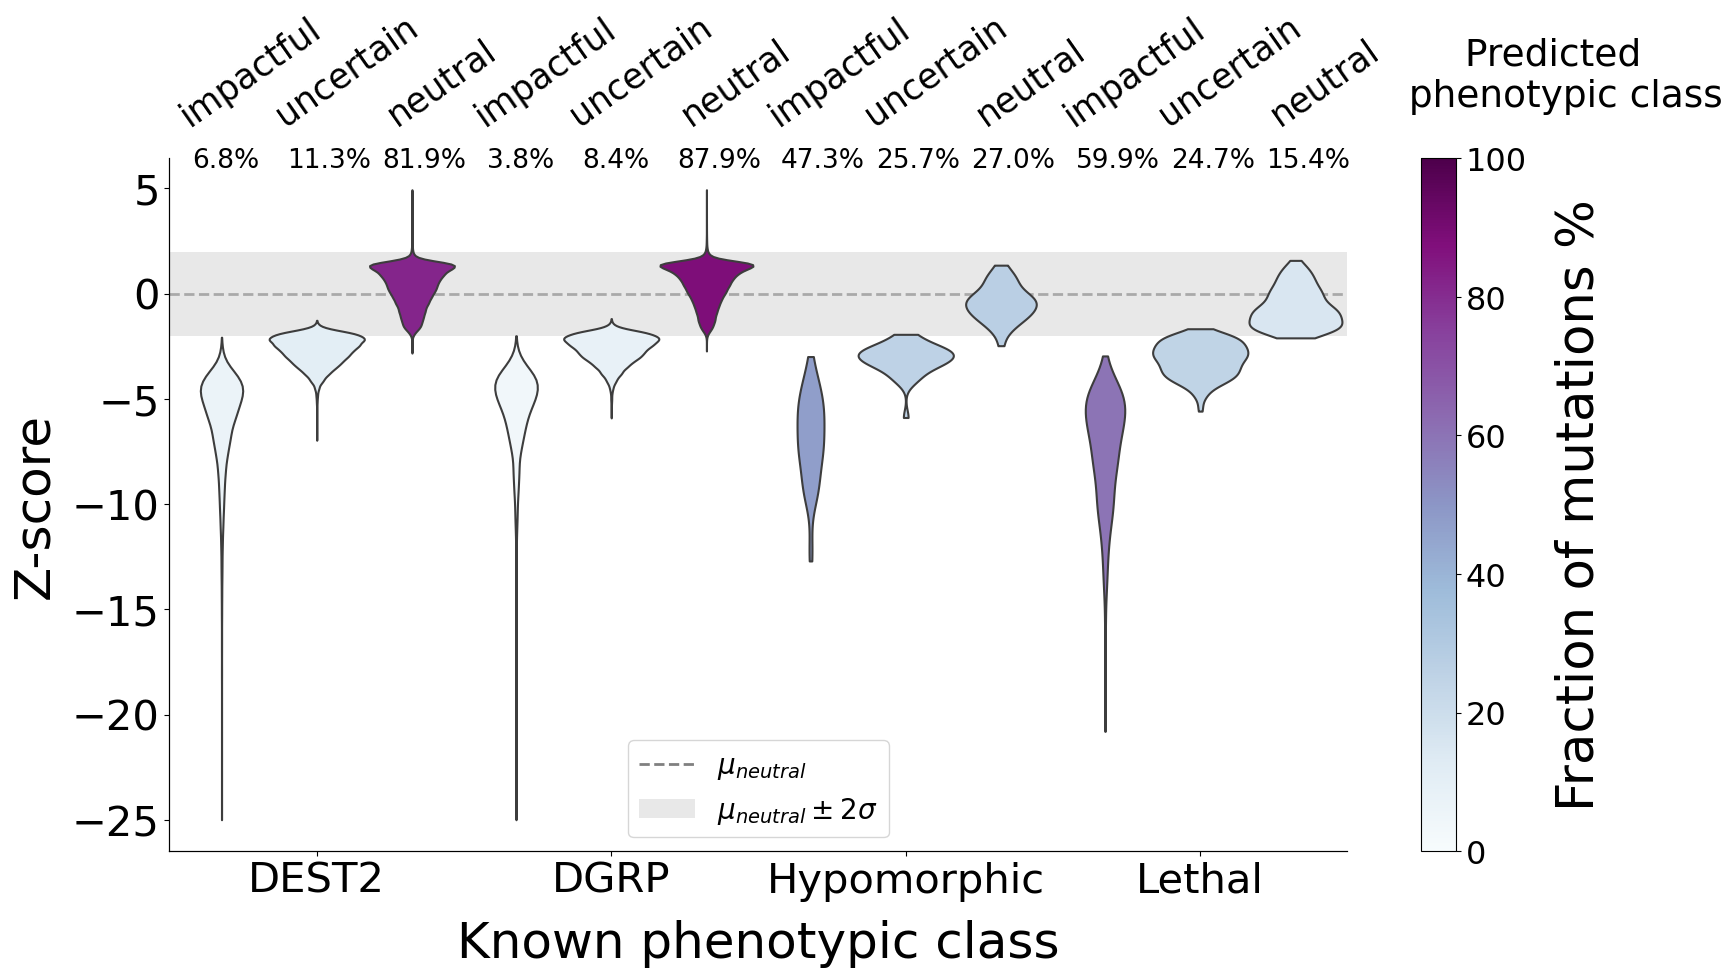

In [373]:
#sns.set(style="ticks")
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.figure(figsize=(19,9))
#sns.set_context("notebook")

df_Benchmark_confset_size=df_BenchPlot.shape[0]
print("the whole df_Benchmark_confset", df_Benchmark_confset_size)
#palette_scp={'DGRP':'#ffbf6e','DGRP1':'#ffbf6e','DGRP2':'#ffbf6e','Lethal':'#ffbf6e'}
palette_bis={'Impactful':'#F07F99', 'Neutral':'#6398D6'}

# Calculate the number of points in each set
num_dgrp_pointsLethal = df_BenchPlot[(df_BenchPlot['Set_name'] == 'DGRP') & (df_BenchPlot['Variant_class'] == 1)].shape[0]
num_dgrp_pointsNeutral = df_BenchPlot[(df_BenchPlot['Set_name'] == 'DGRP') & (df_BenchPlot['Variant_class'] == 0)].shape[0]
num_dgrp_pointsUncert = df_BenchPlot[(df_BenchPlot['Set_name'] == 'DGRP') & (df_BenchPlot['Variant_class'] == 0.5)].shape[0]
print(num_dgrp_pointsLethal, num_dgrp_pointsNeutral, num_dgrp_pointsUncert)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'DGRP') & (df_BenchPlot['Variant_class'] == 1), 'Fractiondf_Benchmark_confset'] = round(num_dgrp_pointsLethal/(num_dgrp_pointsLethal+num_dgrp_pointsNeutral+num_dgrp_pointsUncert), 3)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'DGRP') & (df_BenchPlot['Variant_class'] == 0), 'Fractiondf_Benchmark_confset'] = round(num_dgrp_pointsNeutral/(num_dgrp_pointsLethal+num_dgrp_pointsNeutral+num_dgrp_pointsUncert), 3)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'DGRP') & (df_BenchPlot['Variant_class'] == 0.5), 'Fractiondf_Benchmark_confset'] = round(num_dgrp_pointsUncert/(num_dgrp_pointsLethal+num_dgrp_pointsNeutral+num_dgrp_pointsUncert), 3)

# Calculate the number of points in each set
num_dest_pointsLethal = df_BenchPlot[(df_BenchPlot['Set_name'] == 'DEST2') & (df_BenchPlot['Variant_class'] == 1)].shape[0]
num_dest_pointsNeutral = df_BenchPlot[(df_BenchPlot['Set_name'] == 'DEST2') & (df_BenchPlot['Variant_class'] == 0)].shape[0]
num_dest_pointsUncert = df_BenchPlot[(df_BenchPlot['Set_name'] == 'DEST2') & (df_BenchPlot['Variant_class'] == 0.5)].shape[0]

df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'DEST2') & (df_BenchPlot['Variant_class'] == 1), 'Fractiondf_Benchmark_confset'] = round(num_dest_pointsLethal/(num_dest_pointsLethal+num_dest_pointsNeutral+num_dest_pointsUncert), 3)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'DEST2') & (df_BenchPlot['Variant_class'] == 0), 'Fractiondf_Benchmark_confset'] = round(num_dest_pointsNeutral/(num_dest_pointsLethal+num_dest_pointsNeutral+num_dest_pointsUncert), 3)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'DEST2') & (df_BenchPlot['Variant_class'] == 0.5), 'Fractiondf_Benchmark_confset'] = round(num_dest_pointsUncert/(num_dest_pointsLethal+num_dest_pointsNeutral+num_dest_pointsUncert), 3)



num_lethal_pointsNeutral = df_BenchPlot[(df_BenchPlot['Set_name'] == 'Lethal') & (df_BenchPlot['Variant_class'] == 0)].shape[0]
num_lethal_pointsLethal = df_BenchPlot[(df_BenchPlot['Set_name'] == 'Lethal') & (df_BenchPlot['Variant_class'] == 1)].shape[0]
num_lethal_pointsUncert = df_BenchPlot[(df_BenchPlot['Set_name'] == 'Lethal') & (df_BenchPlot['Variant_class'] == 0.5)].shape[0]

df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'Lethal') & (df_BenchPlot['Variant_class'] == 1), 'Fractiondf_Benchmark_confset'] = round(num_lethal_pointsLethal/(num_lethal_pointsNeutral+num_lethal_pointsLethal+num_lethal_pointsUncert), 3)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'Lethal') & (df_BenchPlot['Variant_class'] == 0), 'Fractiondf_Benchmark_confset'] = round(num_lethal_pointsNeutral/(num_lethal_pointsNeutral+num_lethal_pointsLethal+num_lethal_pointsUncert), 3)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'Lethal') & (df_BenchPlot['Variant_class'] == 0.5), 'Fractiondf_Benchmark_confset'] = round(num_lethal_pointsUncert/(num_lethal_pointsNeutral+num_lethal_pointsLethal+num_lethal_pointsUncert), 3)

num_HyD = df_BenchPlot[(df_BenchPlot['Set_name'] == 'Hypomorphic') & (df_BenchPlot['Variant_class'] == 1)].shape[0]
num_HyN = df_BenchPlot[(df_BenchPlot['Set_name'] == 'Hypomorphic') & (df_BenchPlot['Variant_class'] == 0)].shape[0]
num_HyUn = df_BenchPlot[(df_BenchPlot['Set_name'] == 'Hypomorphic') & (df_BenchPlot['Variant_class'] == 0.5)].shape[0]
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'Hypomorphic') & (df_BenchPlot['Variant_class'] == 1), 'Fractiondf_Benchmark_confset'] = round(num_HyD/(num_HyN+num_HyD+num_HyUn), 3)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'Hypomorphic') & (df_BenchPlot['Variant_class'] == 0), 'Fractiondf_Benchmark_confset'] = round(num_HyN/(num_HyN+num_HyD+num_HyUn), 3)
df_BenchPlot.loc[(df_BenchPlot['Set_name'] == 'Hypomorphic') & (df_BenchPlot['Variant_class'] == 0.5), 'Fractiondf_Benchmark_confset'] = round(num_HyUn/(num_HyN+num_HyD+num_HyUn), 3)


hue_order = ['impactful', 'uncertain', 'neutral']

# Convert 'hue_label' to a categorical type with the specified order
df_BenchPlot['Variant_label'] = pd.Categorical(df_BenchPlot['Variant_label'], categories=hue_order, ordered=True)

# Sort the DataFrame by 'Set_name' and 'hue_label'
df_BenchPlot.sort_values(by=['Set_name', 'Variant_label'], inplace=True)
# Create a color map and normalize it based on the 'Fraction' variable

norm_frac = mcolors.Normalize(vmin=0, vmax=100)
cmap = cm.BuPu

plt.axhline(y=0, color='grey', label = '2 std',  linestyle='dashed', linewidth=2, zorder=1)

plt.axhspan(ymin=-2, ymax=2, facecolor='lightgrey', alpha=0.5, zorder=1)

ax = sns.violinplot(y='GMM3_zscoreNeutral', x='Set_name', data=df_BenchPlot, hue='Variant_label', width=0.97, label=None, inner=None, cut=0, split=False, dodge=True, zorder=1)
#l_numSNPs = [num_dgrp_pointsNeutral, num_dgrp_pointsLethal,num_GOF_N, num_GOF_D, num_HyN, num_HyD, num_lethal_pointsNeutral, num_lethal_pointsLethal]
l_fraction = df_BenchPlot['Fractiondf_Benchmark_confset'].unique()*100 #[ 13.6,  86.4, 71.4, 28.6,  85.8,  14.2]
l_posViolins = [] 
# Iterate over the patches and set their color based on 'Fraction'
for N, violin in enumerate(ax.collections):
    
    color = cmap(norm_frac(l_fraction[N])) ## change the colormap log_norm 
    violin.set_facecolor(color)
    
    paths = violin.get_paths()
    x_positions = [path.vertices[:, 0].mean() for path in paths]  # Calculate mean x-coordinate
    l_posViolins.append(x_positions[0]+0.1)

for i in range(len(l_posViolins)):
   plt.annotate('{:,.1f}%'.format(l_fraction[i]), xy=(l_posViolins[i]-0.2, 6),fontsize=19)


ax.legend_.remove()

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Z-score', fontsize=36, labelpad=10)
plt.xlabel('Known phenotypic class', fontsize=36, labelpad=13)
## alternative

# Create Second x-axis
second_x = ax.twiny()
second_x.set_xlim(ax.get_xlim())  # Set the limit same as the main x-axis

second_x.set_xticks(l_posViolins)  # Set the position for the second x-axis
second_x.set_xticklabels(['impactful', 'uncertain', 'neutral']*4, rotation=35, fontsize=25)
plt.text(1.18, 1.12, 'Predicted \n phenotypic class', fontsize=27, ha='center', va='center', rotation='horizontal', transform=plt.gca().transAxes)
second_x.tick_params(axis='x', which='major', length=0, pad=19,  color='black')
#ax.tick_params(axis='x',pad=10)
# Create a color bar
sm = cm.ScalarMappable(cmap=cmap, norm=norm_frac)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Fraction of mutations %', fontsize=37, labelpad=20)#(log scale)
cbar.ax.tick_params(labelsize=23)
# Hide all spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
second_x.spines['top'].set_visible(False)
second_x.spines['right'].set_visible(False)


# Create custom legend entries
custom_lines = [Line2D([0], [0], color='grey', lw=2, linestyle='dashed'),Patch(facecolor='lightgrey', edgecolor='none', alpha=0.5)]
plt.legend(custom_lines, [r'$\mu_{neutral}$', r'$\mu_{neutral} \pm 2\sigma$'],loc='lower center',fontsize=20)
plt.savefig(f'{WORK_DIR}/Plots/ProteoCast_Benchmark_Fig2.jpg', bbox_inches='tight', dpi=900)

plt.show()
#the whole df_Benchmark_confset 408063
#5155 120530 11462

## Performances of ProteoCast on the benchmark (Table S3)

- with GMM3

In [565]:
from sklearn.metrics import balanced_accuracy_score

In [566]:
print('All')

y_true = df_ProteoCast_Benchmark_PerformanceF1_score.loc[df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['Lethal', 'DGRP', 'DEST2']), 'True_label'].tolist()
y_pred = df_ProteoCast_Benchmark_PerformanceF1_score.loc[df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['Lethal', 'DGRP', 'DEST2']), 'Variant_class'].tolist()

# Convert continuous predictions to binary predictions (uncertain is considered as 1)
threshold = 0.5
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred]
# Calculate the weighted F1 score
weighted_f1 = f1_score(y_true, y_pred_binary, average='weighted')
# Calculate the weights
unique, counts = np.unique(y_true, return_counts=True)
weights = counts / len(y_true)
print(f"Weights: {weights}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")
print('Balanced Accuracy: ', balanced_accuracy_score(y_true, y_pred_binary))
print('DGRP')
y_true = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DGRP']), 'True_label'].tolist()
y_pred = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DGRP']), 'Variant_class'].tolist()

# Convert continuous predictions to binary predictions (uncertain is considered as 1)
threshold = 0.5
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred]
# Calculate the weighted F1 score
weighted_f1 = f1_score(y_true, y_pred_binary, average='weighted')
# Calculate the weights
unique, counts = np.unique(y_true, return_counts=True)
weights = counts / len(y_true)
print(f"Weights: {weights}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")
print('Balanced Accuracy: ', balanced_accuracy_score(y_true, y_pred_binary))


print('DEST2')
y_true = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DEST2']), 'True_label'].tolist()
y_pred = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DEST2']), 'Variant_class'].tolist()

# Convert continuous predictions to binary predictions (uncertain is considered as 1)
threshold = 0.5
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred]
# Calculate the weighted F1 score
weighted_f1 = f1_score(y_true, y_pred_binary, average='weighted')
# Calculate the weights
unique, counts = np.unique(y_true, return_counts=True)
weights = counts / len(y_true)
print(f"Weights: {weights}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")
print('Balanced Accuracy: ', balanced_accuracy_score(y_true, y_pred_binary))


All
Weights: [0.9967933 0.0032067]
Weighted F1 Score: 0.8981
Balanced Accuracy:  0.8328251063802083
DGRP
Weights: [0.99273269 0.00726731]
Weighted F1 Score: 0.9288
Balanced Accuracy:  0.8622213745837655
DEST2
Weights: [0.99629206 0.00370794]
Weighted F1 Score: 0.8972
Balanced Accuracy:  0.8324471181797133


In [564]:
from sklearn.metrics import confusion_matrix
y_true = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DGRP']), 'True_label'].tolist()
y_pred = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DGRP']), 'Variant_class'].tolist()

# Convert continuous predictions to binary predictions (uncertain is considered as 1)
threshold = 0.5
y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred]

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Extract True Positives, False Positives, False Negatives for each class
TP = cm.diagonal()
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP

# Calculate Precision and Recall for each class
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print(precision, recall)
unique, counts = np.unique(y_true, return_counts=True)
weights = counts / len(y_true)
# Calculate F1 Score for each class
f1_scores = 2 * (precision * recall) / (precision + recall)
print(f1_scores, weights)
# Calculate the weighted F1 Score
weighted_f1_manual = sum(f1_scores * weights)

print(f"Weighted F1 Score (manual calculation): {weighted_f1_manual:.4f}")

[0.99871566 0.04860316] [0.87882522 0.84561753]
[0.93494264 0.09192291] [0.99273269 0.00726731]
Weighted F1 Score (manual calculation): 0.9288


In [27]:
print('Specificity \n', df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='Lethal')&(df_ProteoCast_Benchmark_Performance['Variant_class']!=0)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='Lethal')].shape[0])

Specificity 
 0.8456175298804781


In [83]:
print('Sensitivity')
print('DGRP', df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DGRP')&(df_ProteoCast_Benchmark_Performance['Variant_class']==0)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DGRP')].shape[0])
print('DEST2', df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DEST2')&(df_ProteoCast_Benchmark_Performance['Variant_class']==0)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DEST2')].shape[0])
print('Together', df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name'].isin(['DGRP', 'DEST2']))&(df_ProteoCast_Benchmark_Performance['Variant_class']==0)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name'].isin(['DGRP', 'DEST2']))].shape[0])

Sensitivity
DGRP 0.8788252192870528
DEST2 0.8192767064789485
Together 0.8393472838307755


- with universal threshold

In [567]:
# Assuming 'True_label' is the ground truth and 'GMM3_class' is the predicted class
y_true = df_ProteoCast_Benchmark_PerformanceF1_score.loc[df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['Lethal', 'DGRP', 'DEST2']), 'True_label'].tolist()
y_trueDGRP = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DGRP']), 'True_label'].tolist()
y_trueDEST = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DEST2']), 'True_label'].tolist()

y_predAll = df_ProteoCast_Benchmark_PerformanceF1_score.loc[df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['Lethal', 'DGRP', 'DEST2']), 'GEMME_score'].tolist()
y_pred_DGRP = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DGRP']), 'GEMME_score'].tolist()
y_pred_DEST = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DEST2']), 'GEMME_score'].tolist()

specificity_list = []
sensitivity_dgrp_list = []
sensitivity_dest2_list = []
sensitivity_together_list = []
balanced_accuracy_list = []

# Convert continuous predictions to binary predictions
for thresh in [round(x, 3) for x in np.arange(-8, 1, 0.1)]:
    y_pred_binaryAll = [1 if pred <= thresh else 0 for pred in y_predAll]
    y_pred_binaryDGRP = [1 if pred <= thresh else 0 for pred in y_pred_DGRP]
    y_pred_binaryDEST = [1 if pred <= thresh else 0 for pred in y_pred_DEST]
    
    # Calculate the balanced accuracy score
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binaryAll)
    balanced_accuracyDGRP = balanced_accuracy_score(y_trueDGRP, y_pred_binaryDGRP)
    balanced_accuracyDEST = balanced_accuracy_score(y_trueDEST, y_pred_binaryDEST)
    balanced_accuracy_list.append((balanced_accuracy, balanced_accuracyDGRP, balanced_accuracyDEST))

    specificity = round(df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='Lethal')&(df_ProteoCast_Benchmark_Performance['GEMME_score']<=thresh)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='Lethal')].shape[0], 3)
    specificity_list.append(specificity)

    sensitivity_dgrp = round(df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DGRP')&(df_ProteoCast_Benchmark_Performance['GEMME_score']>thresh)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DGRP')].shape[0], 3)
    sensitivity_dgrp_list.append(sensitivity_dgrp)

    sensitivity_dest2 = round(df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DEST2')&(df_ProteoCast_Benchmark_Performance['GEMME_score']>thresh)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DEST2')].shape[0], 3)
    sensitivity_dest2_list.append(sensitivity_dest2)

    sensitivity_together = round(df_ProteoCast_Benchmark_PerformanceF1_score.loc[(df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['DGRP', 'DEST2']))&(df_ProteoCast_Benchmark_PerformanceF1_score['GEMME_score']>thresh)].shape[0]/df_ProteoCast_Benchmark_PerformanceF1_score.loc[(df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['DGRP', 'DEST2']))].shape[0], 3)
    sensitivity_together_list.append(sensitivity_together)


In [572]:
# Assuming 'True_label' is the ground truth and 'GMM3_class' is the predicted class
y_true = df_ProteoCast_Benchmark_PerformanceF1_score.loc[df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['Lethal', 'DGRP', 'DEST2']), 'True_label'].tolist()
y_trueDGRP = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DGRP']), 'True_label'].tolist()
y_trueDEST = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DEST2']), 'True_label'].tolist()

y_predAll = df_ProteoCast_Benchmark_PerformanceF1_score.loc[df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['Lethal', 'DGRP', 'DEST2']), 'GEMME_rank'].tolist()
y_pred_DGRP = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DGRP']), 'GEMME_rank'].tolist()
y_pred_DEST = df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name'].isin(['Lethal', 'DEST2']), 'GEMME_rank'].tolist()

specificity_listR = []
sensitivity_dgrp_listR = []
sensitivity_dest2_listR = []
sensitivity_together_listR = []
balanced_accuracy_listR = []

# Convert continuous predictions to binary predictions
for thresh in [round(x, 3) for x in np.arange(0, 1.1, 0.1)]:
    y_pred_binaryAll = [1 if pred >= thresh else 0 for pred in y_predAll]
    y_pred_binaryDGRP = [1 if pred >= thresh else 0 for pred in y_pred_DGRP]
    y_pred_binaryDEST = [1 if pred >= thresh else 0 for pred in y_pred_DEST]
    
    # Calculate the balanced accuracy score
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binaryAll)
    balanced_accuracyDGRP = balanced_accuracy_score(y_trueDGRP, y_pred_binaryDGRP)
    balanced_accuracyDEST = balanced_accuracy_score(y_trueDEST, y_pred_binaryDEST)
    
    balanced_accuracy_listR.append((balanced_accuracy, balanced_accuracyDGRP, balanced_accuracyDEST))

    specificity = round(df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='Lethal')&(df_ProteoCast_Benchmark_Performance['GEMME_rank']>=thresh)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='Lethal')].shape[0], 3)
    specificity_listR.append(specificity)

    sensitivity_dgrp = round(df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DGRP')&(df_ProteoCast_Benchmark_Performance['GEMME_rank']<thresh)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DGRP')].shape[0], 3)
    sensitivity_dgrp_listR.append(sensitivity_dgrp)

    sensitivity_dest2 = round(df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DEST2')&(df_ProteoCast_Benchmark_Performance['GEMME_rank']<thresh)].shape[0]/df_ProteoCast_Benchmark_Performance.loc[(df_ProteoCast_Benchmark_Performance['Set_name']=='DEST2')].shape[0], 3)
    sensitivity_dest2_listR.append(sensitivity_dest2)

    sensitivity_together = round(df_ProteoCast_Benchmark_PerformanceF1_score.loc[(df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['DGRP', 'DEST2']))&(df_ProteoCast_Benchmark_PerformanceF1_score['GEMME_rank']<thresh)].shape[0]/df_ProteoCast_Benchmark_PerformanceF1_score.loc[(df_ProteoCast_Benchmark_PerformanceF1_score['Set_name'].isin(['DGRP', 'DEST2']))].shape[0], 3)
    sensitivity_together_listR.append(sensitivity_together)


Best threshold (closest to (0,1)): 0.5
Best threshold (closest to (0,1)): 0.6
Best threshold (closest to (0,1)): 0.6


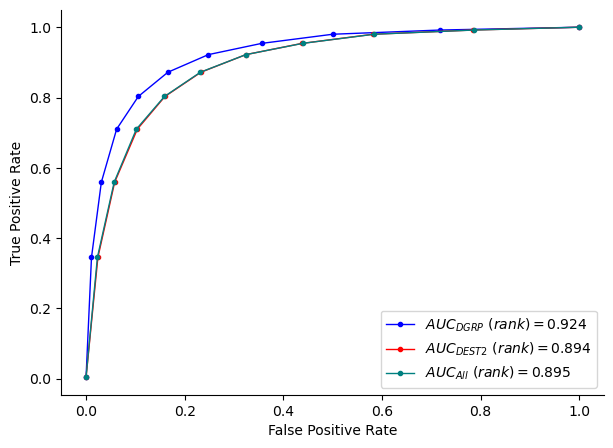

In [573]:
thresholdsR = [round(x, 3) for x in np.arange(0, 1.1, 0.1)]
plt.figure(figsize=(7, 5))

distancesR = np.sqrt((1 - np.array(specificity_listR)) ** 2 + (1 - np.array(sensitivity_dgrp_listR)) ** 2)
print("Best threshold (closest to (0,1)):", thresholdsR[np.argmin(distancesR)])
roc_aucR = auc(1 - np.array(sensitivity_dgrp_listR), specificity_listR)
plt.plot(1 - np.array(sensitivity_dgrp_listR), specificity_listR, marker='o', lw=1, markersize=3, color='blue', label='$AUC_{DGRP}\ (rank) = %0.3f$' % roc_aucR)

distancesR = np.sqrt((1 - np.array(specificity_listR)) ** 2 + (1 - np.array(sensitivity_dest2_listR)) ** 2)
print("Best threshold (closest to (0,1)):", thresholdsR[np.argmin(distancesR)])
roc_aucR = auc(1 - np.array(sensitivity_dest2_listR), specificity_listR)
plt.plot(1 - np.array(sensitivity_dest2_listR), specificity_listR, marker='o', markersize=3, lw=1, color='red', label='$AUC_{DEST2}\ (rank) = %0.3f$' % roc_aucR)

distancesR = np.sqrt((1 - np.array(specificity_listR)) ** 2 + (1 - np.array(sensitivity_together_listR)) ** 2)
print("Best threshold (closest to (0,1)):", thresholdsR[np.argmin(distancesR)])
roc_aucR = auc(1 - np.array(sensitivity_together_listR), specificity_listR)
plt.plot(1 - np.array(sensitivity_together_listR), specificity_listR, marker='o', markersize=3, lw=1, color='teal', label='$AUC_{All}\ (rank) = %0.3f$' % roc_aucR)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.savefig(f'{WORK_DIR}/Plots/ProteoCast_ROCrank.jpg', bbox_inches='tight', dpi=900)
plt.show()


Best threshold (closest to (0,1)): -2.2
Best threshold (closest to (0,1)): -2.4
Best threshold (closest to (0,1)): -2.4


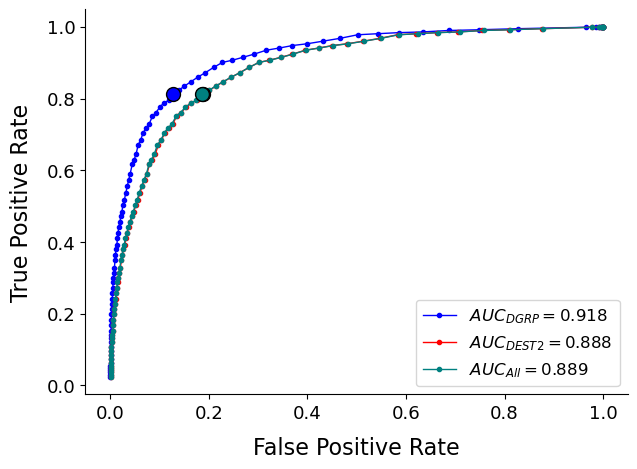

In [583]:
thresholds = [round(x, 3) for x in np.arange(-8, 1, 0.1)]
plt.figure(figsize=(7, 5))

distances = np.sqrt((1 - np.array(specificity_list)) ** 2 + (1-np.array(sensitivity_dgrp_list) )** 2)
best_thresh_ind = thresholds.index(-2.4)
print("Best threshold (closest to (0,1)):",thresholds[np.argmin(distances)])
roc_auc = auc(1-np.array(sensitivity_dgrp_list), specificity_list)
plt.plot(1-np.array(sensitivity_dgrp_list), specificity_list, marker='o', lw=1, markersize=3, color='blue', label='$AUC_{DGRP} = %0.3f$' % roc_auc)
plt.scatter(1-np.array(sensitivity_dgrp_list)[best_thresh_ind], specificity_list[best_thresh_ind], color='blue', s=100, edgecolor='black', zorder=5)

distances = np.sqrt((1 - np.array(specificity_list)) ** 2 + (1-np.array(sensitivity_dest2_list) )** 2)
print("Best threshold (closest to (0,1)):", thresholds[np.argmin(distances)])
roc_auc = auc(1-np.array(sensitivity_dest2_list), specificity_list)
plt.plot(1-np.array(sensitivity_dest2_list), specificity_list, marker='o', markersize=3, lw=1,  color='red', label='$AUC_{DEST2}= %0.3f$' % roc_auc)
plt.scatter(1-np.array(sensitivity_dest2_list)[best_thresh_ind], specificity_list[best_thresh_ind], color='red', s=100, edgecolor='black', zorder=5)

distances = np.sqrt((1 - np.array(specificity_list)) ** 2 + (1-np.array(sensitivity_together_list) )** 2)
print("Best threshold (closest to (0,1)):", thresholds[np.argmin(distances)])
roc_auc = auc(1-np.array(sensitivity_together_list), specificity_list)
plt.plot(1-np.array(sensitivity_together_list), specificity_list, marker='o', markersize=3, lw=1,  color='teal', label='$AUC_{All} = %0.3f$' % roc_auc)
plt.scatter(1-np.array(sensitivity_together_list)[best_thresh_ind], specificity_list[best_thresh_ind], color='teal', s=100, edgecolor='black', zorder=5)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=16, labelpad=10)
plt.ylabel('True Positive Rate', fontsize=16, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(f'{WORK_DIR}/Plots/ProteoCast_ROCraw.jpg', bbox_inches='tight', dpi=900)
plt.show()


In [571]:
thresholds = [round(x, 3) for x in np.arange(-8, 1, 0.1)]
best_thresh_ind = thresholds.index(-2.4)
print(balanced_accuracy_list[best_thresh_ind], specificity_list[best_thresh_ind], sensitivity_dgrp_list[best_thresh_ind], sensitivity_dest2_list[best_thresh_ind], sensitivity_together_list[best_thresh_ind], thresholds[best_thresh_ind])

(0.8127268362545843, 0.8422726857192191, 0.812365249528786) 0.813 0.872 0.812 0.813 -2.4


In [574]:
thresholdsR = [round(x, 3) for x in np.arange(0, 1.1, 0.1)]
best_thresh_indR = thresholdsR.index(0.6)
print(balanced_accuracy_listR[best_thresh_indR], specificity_listR[best_thresh_indR], sensitivity_dgrp_listR[best_thresh_indR], sensitivity_dest2_listR[best_thresh_indR], sensitivity_together_listR[best_thresh_indR], thresholdsR[best_thresh_indR])

(0.8218612748212507, 0.8485686634645386, 0.8213546841673289) 0.803 0.894 0.84 0.841 0.6


## overlapping genes in the benchmark

In [ ]:
# Get the unique genes in the Hypomorphic and Lethal datasets
hypomorphic_genes = set(df_Benchmark_conf.loc[df_Benchmark_conf['Set_name'] == 'Hypomorphic', 'FBgn_ID'])
lethal_genes = set(df_Benchmark_conf.loc[df_Benchmark_conf['Set_name'] == 'Lethal', 'FBgn_ID'])
dgrp_genes = set(df_Benchmark_conf.loc[df_Benchmark_conf['Set_name'] == 'DGRP', 'FBgn_ID'])

# Find the overlap between the two sets
overlap_genes = hypomorphic_genes.intersection(lethal_genes)
overlap_DGRP_lethal = lethal_genes.intersection(dgrp_genes)


# Print the number of overlapping genes and the genes themselves
print(f"Number of overlapping genes: {len(overlap_genes)}")
print("Overliapping DGRP lethal:", len(overlap_DGRP_lethal))
print("Overlapping genes:", overlap_genes)

# Filter the df_Benchmark_conf dataframe for the overlap_genes
overlap_genes_df = df_Benchmark_conf[df_Benchmark_conf['FBgn_ID'].isin(overlap_genes)]

# Separate the lethal and hypomorphic genes
lethal_genes_df = overlap_genes_df[overlap_genes_df['Set_name'] == 'Lethal']
hypomorphic_genes_df = overlap_genes_df[overlap_genes_df['Set_name'] == 'Hypomorphic']

# Calculate the mean and standard deviation of GEMME_Value for lethal and hypomorphic genes
mean_gemme_lethal = lethal_genes_df['GEMME_Value_Fobs'].mean()
std_gemme_lethal = lethal_genes_df['GEMME_Value_Fobs'].std()
mean_gemme_hypomorphic = hypomorphic_genes_df['GEMME_Value_Fobs'].mean()
std_gemme_hypomorphic = hypomorphic_genes_df['GEMME_Value_Fobs'].std()
print(f"Mean GEMME_Value for lethal genes: {mean_gemme_lethal:.2f}, Std: {std_gemme_lethal:.2f}")
print(f"Mean GEMME_Value for hypomorphic genes: {mean_gemme_hypomorphic:.2f}, Std: {std_gemme_hypomorphic:.2f}")

# Compare the mean GEMME_Value
if mean_gemme_lethal < mean_gemme_hypomorphic:
    print("Lethal genes are predicted as more impactful than hypomorphic genes.")
else:
    print("Hypomorphic genes are predicted as more impactful than lethal genes.")

## Allele Frequencies vs GEMME_ranks FigS3

In [585]:
df_DEST = pd.read_csv('../csv/'+'DEST_maxFobsProteoforms.csv')
df_DEST['Freq'] = df_DEST['INFO'].apply(lambda x: float(re.search(r'AF=([\d\.]+)', x).group(1)))
df_DEST['Depth'] = df_DEST['INFO'].apply(lambda x: float(re.search(r'ADP=([\d\.]+)', x).group(1)))
df_DEST['NC'] = df_DEST['INFO'].apply(lambda x: float(re.search(r'NC=([\d\.]+)', x).group(1)))
df_DEST = df_DEST.loc[~df_DEST['GEMME_rank'].isnull()].copy()

'''

# Calculate the correlation matrix
correlation_matrix = df_DEST[['Freq', 'Depth', 'NC', 'GEMME_score']].corr()
print(correlation_matrix)
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()'''

# Pairplot to visualize relationships
#sns.pairplot(df_DEST[['Freq', 'Depth', 'NC', 'GEMME_score']])
#plt.show()

"\n\n# Calculate the correlation matrix\ncorrelation_matrix = df_DEST[['Freq', 'Depth', 'NC', 'GEMME_score']].corr()\nprint(correlation_matrix)\n# Plot the correlation matrix as a heatmap\nplt.figure(figsize=(8, 6))\nsns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)\nplt.title('Correlation Matrix')\nplt.show()"

In [586]:
## DGRP
df_DGRP_Freq = pd.read_csv(f'../csv/DGRP_SNPfreq.csv')
df_DGRP_Freq.rename(columns={'id':'SNP_ID'}, inplace=True)
df_DGRP = pd.read_csv(f'../csv/DGRP_maxFobsProteoforms.csv', sep=',')
df_DGRP = df_DGRP.merge(df_DGRP_Freq, on='SNP_ID', how='left')

In [587]:
def MAFanalysis(column, quantiles):
    
    quantile_bordersDEST = [df_DEST[column].min()] + list(np.quantile(df_DEST[column],quantiles))
    quantile_bordersDGRP = [df_DGRP[column].min()] + list(np.quantile(df_DGRP[column],quantiles))
    print(quantile_bordersDEST, quantile_bordersDGRP)
    
    df_DEST['category'] = pd.cut(df_DEST[column], bins=quantile_bordersDEST, labels=list(np.arange(1, len(quantiles)+1)), include_lowest=True)
    df_DGRP['category'] = pd.cut(df_DGRP[column], bins=quantile_bordersDGRP, labels=list(np.arange(1, len(quantiles)+1)), include_lowest=True)

    meanMAN_perbinDEST = df_DEST.groupby('category')['Freq'].mean()
    meanMAN_perbinDGRP = df_DGRP.groupby('category')['MAF_A'].mean()
    print('Number of points per category',  df_DEST.groupby('category')['Freq'].count().tolist())
    print('Number of points per category',  df_DGRP.groupby('category')['MAF_A'].count().tolist())
    print(meanMAN_perbinDEST.tolist(), meanMAN_perbinDGRP.tolist())
    plt.figure(figsize=(10, 6))
    plt.plot(quantiles, meanMAN_perbinDEST, marker='o', label='DEST2', color='#76D6FF', alpha=0.9, markersize=9, linewidth=2)
    plt.plot(quantiles, meanMAN_perbinDGRP, marker='o', label='DGRP', markersize=9, linewidth=2)
    plt.ylabel('mean MAF')
    plt.xlabel(column)
    plt.yscale('log')  # Change the y-scale to logarithmic
    plt.xscale('log')  # Change the x-scale to logarithmic
    plt.grid(False)
    plt.legend(loc='upper left')
    # Set custom ticks for x-axis
    if column =='GEMME_rank':
        plt.xticks([0.1,0.5, 0.9, 0.99, 1])
        plt.gca().invert_xaxis()
    else:
        plt.xticks([0.0001, 0.001, 0.01, 0.1, 1], ['$10^{-4}$','$10^{-3}$', '$10^{-2}$','$10^{-1}$','$10^{0}$'])

    # Set custom ticks for y-axis (example)
    plt.yticks([0.001, 0.01, 0.1, 1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'])

    # Remove top and right borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.show()

[-9.50713414731181, -7.593863507108889, -5.948419402066214, -3.18436739880589, -2.19762700118427, -1.62287391569913, -1.20437973787147, -0.861073967832492, -0.578950738446704, -0.3454545123422033, -0.166075273534112, -0.0424463740639956, 2.39623470720515] [-8.83861601857209, -7.0005662719752015, -5.052279899376836, -2.58816131612518, -1.781331200363832, -1.29698184607232, -0.9237440633599452, -0.632438906050441, -0.3980238493840376, -0.2195154623422927, -0.09241752023928249, -0.017033769623477957, 2.39623470720515]
Number of points per category [332, 2982, 29821, 33134, 33134, 33134, 33134, 33134, 33133, 33135, 33134, 33134]
Number of points per category [178, 1593, 15931, 17701, 17701, 17701, 17702, 17701, 17701, 17701, 17701, 17702]
[0.005056634638554217, 0.0066527673340040245, 0.011325729495657423, 0.01771768151445645, 0.023839727546327034, 0.028213944591658116, 0.031738822626908914, 0.03776854732782036, 0.04585523829475146, 0.060888883589557866, 0.09716447811070199, 0.1873455623501

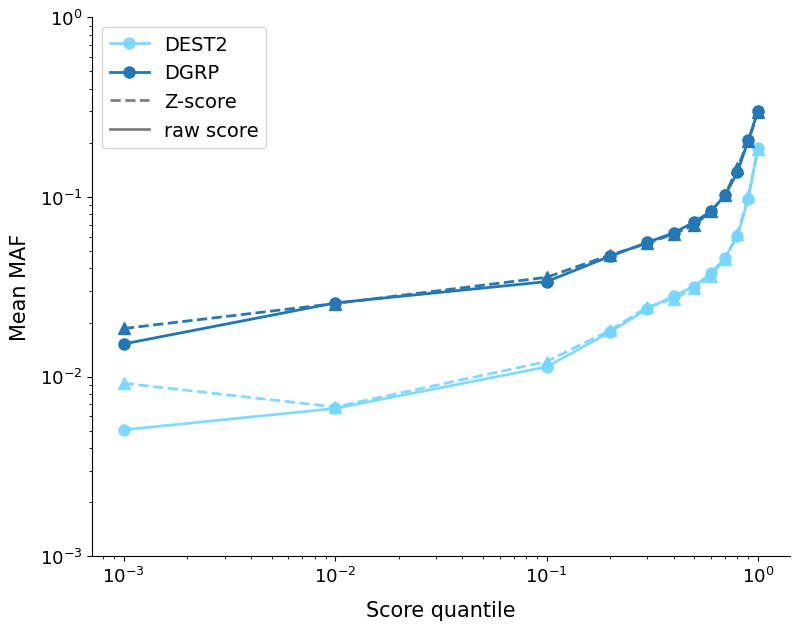

In [590]:
quantiles = [0.001,0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
column = 'GEMME_score'
quantile_bordersDEST = [df_DEST[column].min()] + list(np.quantile(df_DEST[column],quantiles))
quantile_bordersDGRP = [df_DGRP[column].min()] + list(np.quantile(df_DGRP[column],quantiles))
print(quantile_bordersDEST, quantile_bordersDGRP)

df_DEST['category'] = pd.cut(df_DEST[column], bins=quantile_bordersDEST, labels=list(np.arange(1, len(quantiles)+1)), include_lowest=True)
df_DGRP['category'] = pd.cut(df_DGRP[column], bins=quantile_bordersDGRP, labels=list(np.arange(1, len(quantiles)+1)), include_lowest=True)

meanMAN_perbinDEST = df_DEST.groupby('category')['Freq'].mean()
meanMAN_perbinDGRP = df_DGRP.groupby('category')['MAF_A'].mean()
print('Number of points per category',  df_DEST.groupby('category')['Freq'].count().tolist())
print('Number of points per category',  df_DGRP.groupby('category')['MAF_A'].count().tolist())
print(meanMAN_perbinDEST.tolist(), meanMAN_perbinDGRP.tolist())
plt.figure(figsize=(9, 7))
plt.plot(quantiles, meanMAN_perbinDEST, marker='o', label='DEST2', color='#76D6FF', alpha=0.9, markersize=8, linewidth=2)
plt.plot(quantiles, meanMAN_perbinDGRP, marker='o', label='DGRP', markersize=8, linewidth=2)

column = 'GMM3_zscoreNeutral'
quantile_bordersDEST = [df_DEST[column].min()] + list(np.quantile(df_DEST[column],quantiles))
quantile_bordersDGRP = [df_DGRP[column].min()] + list(np.quantile(df_DGRP[column],quantiles))
print(quantile_bordersDEST, quantile_bordersDGRP)

df_DEST['category'] = pd.cut(df_DEST[column], bins=quantile_bordersDEST, labels=list(np.arange(1, len(quantiles)+1)), include_lowest=True)
df_DGRP['category'] = pd.cut(df_DGRP[column], bins=quantile_bordersDGRP, labels=list(np.arange(1, len(quantiles)+1)), include_lowest=True)

meanMAN_perbinDEST = df_DEST.groupby('category')['Freq'].mean()
meanMAN_perbinDGRP = df_DGRP.groupby('category')['MAF_A'].mean()
print('Number of points per category',  df_DEST.groupby('category')['Freq'].count().tolist())
print('Number of points per category',  df_DGRP.groupby('category')['MAF_A'].count().tolist())
print(meanMAN_perbinDEST.tolist(), meanMAN_perbinDGRP.tolist())

plt.plot(quantiles, meanMAN_perbinDEST, '--', marker='^', color='#76D6FF', alpha=0.9, markersize=8, linewidth=2)
plt.plot(quantiles, meanMAN_perbinDGRP, '--', marker='^',color='#2777B4' , markersize=8, linewidth=2)
plt.plot([], [], '--',color='grey' , label='Z-score', markersize=9, linewidth=2)
plt.plot([], [], '-',color='grey' , label='raw score', markersize=9, linewidth=2)


plt.ylabel('Mean MAF', fontsize=15, labelpad=7)
plt.xlabel('Score quantile', fontsize=15, labelpad=10)
plt.yscale('log')  # Change the y-scale to logarithmic
plt.xscale('log')  # Change the x-scale to logarithmic
plt.grid(False)
plt.legend(loc='upper left', fontsize=14)
# Set custom ticks for x-axis

plt.xticks([ 0.001, 0.01, 0.1, 1], ['$10^{-3}$', '$10^{-2}$','$10^{-1}$','$10^{0}$'], fontsize=13)

# Set custom ticks for y-axis (example)
plt.yticks([0.001, 0.01, 0.1, 1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$'], fontsize=13)

# Remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(f'{WORK_DIR}/Plots/'+f'MAF_GEMMEscore.jpg', format='jpg', dpi=600)
plt.show()

## Fig S4

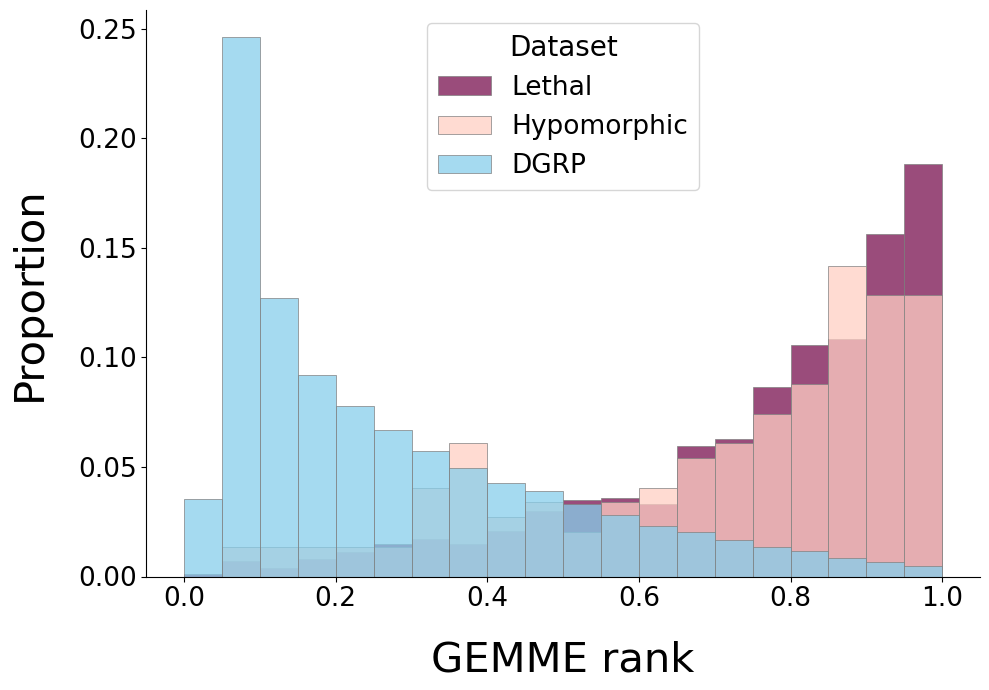

In [214]:
plt.figure(figsize=(10, 7))                          
bin_width = 0.05


# Define the range of your data
data_min = df_ProteoCast_Benchmark_Performance['GEMME_rank'].min()
data_max = df_ProteoCast_Benchmark_Performance['GEMME_rank'].max() 
# Generate bin edges
bins_custom = np.arange(data_min, data_max + bin_width, bin_width)



ax = sns.histplot(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='Lethal', 'GEMME_rank'], bins=bins_custom, stat='proportion', color='#6f0043', alpha=0.7, edgecolor='grey', linewidth=0.5,label = 'Lethal', fill=True) 
ax = sns.histplot(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='Hypomorphic', 'GEMME_rank'], bins=bins_custom,  stat='proportion', color='#ffcfc4',edgecolor='grey', linewidth=0.5,label='Hypomorphic', fill=True)
#ax = sns.histplot(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='DEST2', 'GEMME_rank'], bins=bins_custom,  stat='proportion', color='#2777B4', alpha=0.7, edgecolor='grey', linewidth=0.5,label='DEST2', fill=True) 
ax = sns.histplot(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='DGRP', 'GEMME_rank'], bins=bins_custom,  stat='proportion', color='skyblue', edgecolor='grey', linewidth=0.5,label='DGRP', fill=True)


plt.xlabel('GEMME rank', fontsize=30, labelpad=20)
plt.ylabel('Proportion', fontsize=30, labelpad=20)
plt.xticks(fontsize=19)
plt.yticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize=19)

legend = plt.legend(fontsize=19, title='Dataset',alignment='center', title_fontsize=20)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{WORK_DIR}/Plots/GEMMErankDistribDGRP.jpg', dpi=800)
plt.show()



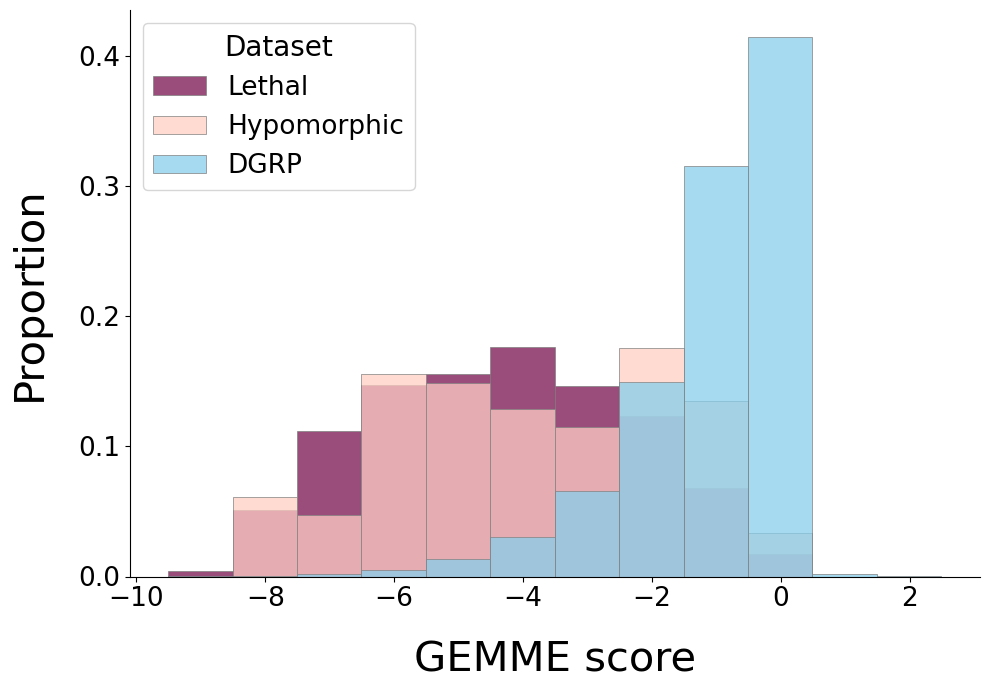

In [ ]:
plt.figure(figsize=(10, 7))                          
bin_width = 1

# Define the range of your data
data_min = df_ProteoCast_Benchmark_Performance['GEMME_score'].min()
data_max = df_ProteoCast_Benchmark_Performance['GEMME_score'].max() 
# Generate bin edges
bins_custom = np.arange(data_min, data_max + bin_width, bin_width)



ax = sns.histplot(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='Lethal', 'GEMME_score'], bins=bins_custom, stat='proportion', color='#6f0043', alpha=0.7, edgecolor='grey', linewidth=0.5,label = 'Lethal', fill=True) 
ax = sns.histplot(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='Hypomorphic', 'GEMME_score'], bins=bins_custom,  stat='proportion', color='#ffcfc4',edgecolor='grey', linewidth=0.5,label='Hypomorphic', fill=True)
#ax = sns.histplot(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='DEST2', 'GEMME_score'], bins=bins_custom,  stat='proportion', color='#2777B4', alpha=0.7, edgecolor='grey', linewidth=0.5,label='DEST2', fill=True) 
ax = sns.histplot(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='DGRP', 'GEMME_score'], bins=bins_custom,  stat='proportion', color='skyblue', edgecolor='grey', linewidth=0.5,label='DGRP', fill=True)


plt.xlabel('GEMME score', fontsize=30, labelpad=20)
plt.ylabel('Proportion', fontsize=30, labelpad=20)
plt.xticks(fontsize=19)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4], fontsize=19)

# Add legend with custom order
#plt.legend(handles=handles, labels=labels, fontsize=19, loc='upper left')
legend = plt.legend(fontsize=19, title='Dataset',alignment='center', title_fontsize=20)

# Align the legend title to the left
#plt.setp(legend.get_title(), multialignment='right')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{WORK_DIR}/Plots/GEMMEscoresDistribDGRP.jpg', dpi=800)
plt.show()


## Fobs

In [421]:
# Group by 'FBgn_ID' and get the index of the row with the highest 'F_obs' value for each group
idx = df_Dmel_recap_Conf.groupby('FBgn_ID')['F_obs'].idxmax()

# Filter the DataFrame to keep only the rows with the highest 'F_obs' value for each gene
df_Fobs = df_Dmel_recap_Conf.loc[idx, ['FBgn_ID', 'Length', 'F_obs', 'n_Lethal','n_Hypomorphic', 'n_DEST_DGRP_union', 'GMM3_uncertain', 'GMM3_impactful']].reset_index(drop=False)

l_genes95 = df_Fobs.loc[df_Fobs['F_obs'] >= 95, 'FBgn_ID'].tolist()
l_genesRest = df_Fobs.loc[df_Fobs['F_obs'] < 95, 'FBgn_ID'].tolist()

df_Fobs.set_index('FBgn_ID', inplace=True)
# Join with interaction data
df_Fobs = df_Fobs.join(df_Interaction[['NumPhysicalInter']], how='left')

print(len(l_genes95), len(l_genesRest))

'''# Get unique gene lists
l_genePoly = df_Fobs.loc[df_Fobs['Num_Polymorphic_Residues'] != 0, 'FBgn_ID'].unique()
l_geneLethal = df_Fobs.loc[df_Fobs['Num_Lethal_SNPs'] != 0, 'FBgn_ID'].unique()
l_geneLethal_noPoly = df_Fobs.loc[(df_Fobs['Num_Lethal_SNPs'] != 0) & (df_Fobs['Num_Polymorphic_Residues'] == 0), 'FBgn_ID'].unique()
l_genenoPoly = df_Fobs.loc[df_Fobs['Num_Polymorphic_Residues'] == 0, 'FBgn_ID'].unique()

# Set index and assign categories

df_Fobs['Category'] = 'NoPoly'
df_Fobs.loc[l_genePoly, 'Category'] = 'Polymorphic'
df_Fobs.loc[l_geneLethal, 'Category'] = 'Lethal'
df_Fobs.loc[l_geneLethal_noPoly, 'Category'] = 'Lethal_noPoly'''



593 10971


"# Get unique gene lists\nl_genePoly = df_Fobs.loc[df_Fobs['Num_Polymorphic_Residues'] != 0, 'FBgn_ID'].unique()\nl_geneLethal = df_Fobs.loc[df_Fobs['Num_Lethal_SNPs'] != 0, 'FBgn_ID'].unique()\nl_geneLethal_noPoly = df_Fobs.loc[(df_Fobs['Num_Lethal_SNPs'] != 0) & (df_Fobs['Num_Polymorphic_Residues'] == 0), 'FBgn_ID'].unique()\nl_genenoPoly = df_Fobs.loc[df_Fobs['Num_Polymorphic_Residues'] == 0, 'FBgn_ID'].unique()\n\n# Set index and assign categories\n\ndf_Fobs['Category'] = 'NoPoly'\ndf_Fobs.loc[l_genePoly, 'Category'] = 'Polymorphic'\ndf_Fobs.loc[l_geneLethal, 'Category'] = 'Lethal'\ndf_Fobs.loc[l_geneLethal_noPoly, 'Category'] = 'Lethal_noPoly"

- interactions 

In [414]:
print(df_Fobs.loc[(df_Fobs.index.isin(l_genes95))&(df_Fobs['NumPhysicalInter']>20)].shape[0],round(df_Fobs.loc[(df_Fobs.index.isin(l_genes95))&(df_Fobs['NumPhysicalInter']>20)].shape[0]/len(l_genes95), 2))
print(df_Fobs.loc[(df_Fobs.index.isin(l_genesRest))&(df_Fobs['NumPhysicalInter']>20)].shape[0],round(df_Fobs.loc[(df_Fobs.index.isin(l_genesRest))&(df_Fobs['NumPhysicalInter']>20)].shape[0]/len(l_genesRest), 2))
## 17/6=2.83 fold 

100 0.17
647 0.06


- lethal mutations

In [418]:
print(df_Fobs.loc[(df_Fobs.index.isin(l_genes95))&(df_Fobs['n_Lethal']!=0)].shape[0],round(df_Fobs.loc[(df_Fobs.index.isin(l_genes95))&(df_Fobs['n_Lethal']!=0)].shape[0]/len(l_genes95), 2))
print(df_Fobs.loc[(df_Fobs.index.isin(l_genesRest))&(df_Fobs['n_Lethal']!=0)].shape[0],round(df_Fobs.loc[(df_Fobs.index.isin(l_genesRest))&(df_Fobs['n_Lethal']!=0)].shape[0]/len(l_genesRest), 2))
## 7/4=1.75 fold 

41 0.07
416 0.04


In [431]:
l_hypo = set(df_ProteoCast_Benchmark_Performance.loc[df_ProteoCast_Benchmark_Performance['Set_name']=='Hypomorphic', 'FBgn_ID'].tolist())
print(len(set(l_genes95).intersection(set(l_hypo))), len(set(l_genesRest).intersection(set(l_hypo))))
print(df_Fobs.loc[(df_Fobs.index.isin(l_genes95))&(df_Fobs['n_Hypomorphic']!=0)].shape[0],round(df_Fobs.loc[(df_Fobs.index.isin(l_genes95))&(df_Fobs['n_Hypomorphic']!=0)].shape[0]/len(l_genes95), 2))
print(df_Fobs.loc[(df_Fobs.index.isin(l_genesRest))&(df_Fobs['n_Hypomorphic']!=0)].shape[0],round(df_Fobs.loc[(df_Fobs.index.isin(l_genesRest))&(df_Fobs['n_Hypomorphic']!=0)].shape[0]/len(l_genesRest), 2))
## 7/4=1.75 fold 

7 99
20 0.03
205 0.02


In [433]:
7/len(l_genes95), 99/len(l_genesRest)

(0.011804384485666104, 0.009023789991796555)

## Fig S12

In [14]:
df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap['GEMME_GlobalConfidence']==True)&(~df_Dmel_recap['F_obs'].isnull())].shape

(19421, 27)

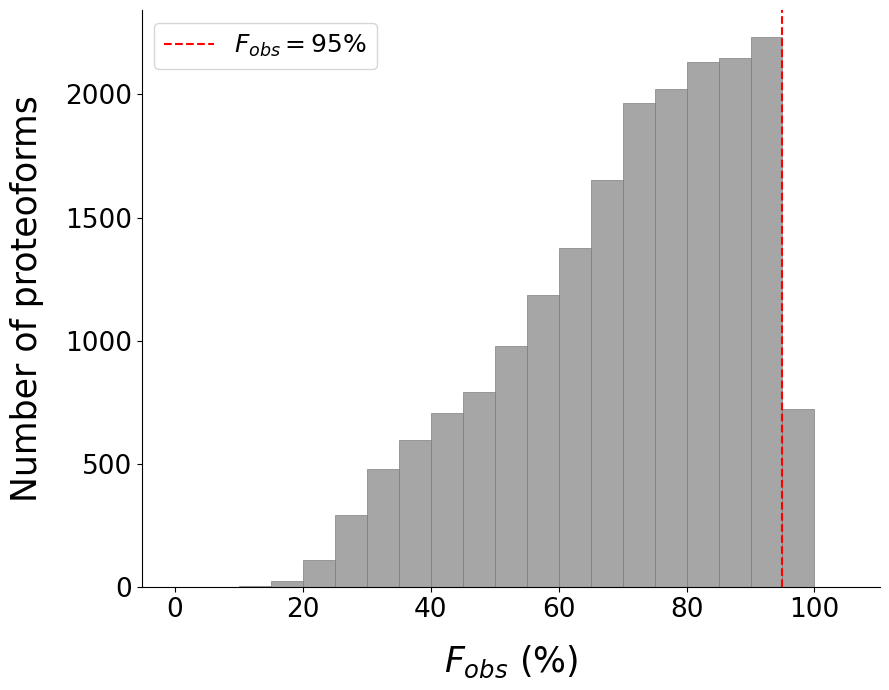

In [92]:
plt.figure(figsize=(9, 7))                      
bin_width = 5
# Define the range of your data
data_min = df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap['GEMME_GlobalConfidence']==True), 'F_obs'].min()
data_max = df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap['GEMME_GlobalConfidence']==True),'F_obs'].max() 
# Generate bin edges
bins_custom = np.arange(0, 110, bin_width)
ax = sns.histplot(df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap['GEMME_GlobalConfidence']==True), 'F_obs'], bins=bins_custom,  color='grey',alpha=0.7, edgecolor='grey', linewidth=0.5,fill=True)
plt.xlabel(r'$F_{obs}\ (\%)$', fontsize=25, labelpad=15)
plt.ylabel('Number of proteoforms', fontsize=25, labelpad=15)
plt.xticks( fontsize=19)
plt.yticks( fontsize=19)
#plt.yticks([0,1000, 2000, 3000, 4000], fontsize=25)

plt.axvline(x=95, color='red', linestyle='--', label=r'$F_{obs}=95\%$')
legend=plt.legend(fontsize=18, loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{WORK_DIR}/Plots/F_obsDistrib_Proteoforms.jpg', dpi=800)

plt.show()
plt.close()

In [93]:
plt.figure(figsize=(9, 7))                      
bin_width = 5
# Define the range of your data
data_min = df_Fobs['F_obs'].min()
data_max = df_Fobs['F_obs'].max() 
# Generate bin edges
bins_custom = np.arange(0, 110, bin_width)
ax = sns.histplot(df_Fobs['F_obs'], bins=bins_custom,  color='grey',alpha=0.7, edgecolor='grey', linewidth=0.5,fill=True)
plt.xlabel(r'$F_{obs}\ (\%)$', fontsize=25, labelpad=15)
plt.ylabel('Number of genes', fontsize=25, labelpad=15)
plt.xticks( fontsize=19)
plt.yticks( fontsize=19)
#plt.yticks([0,1000, 2000, 3000, 4000], fontsize=25)

plt.axvline(x=95, color='red', linestyle='--', label=r'$F_{obs}=95\%$')
legend=plt.legend(fontsize=18, loc='upper left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{WORK_DIR}/Plots/F_obsDistrib_Genes.jpg', dpi=800)

#plt.show()
plt.close()

## Fig S14 (to update)

-3.063 -1.8474706025991383


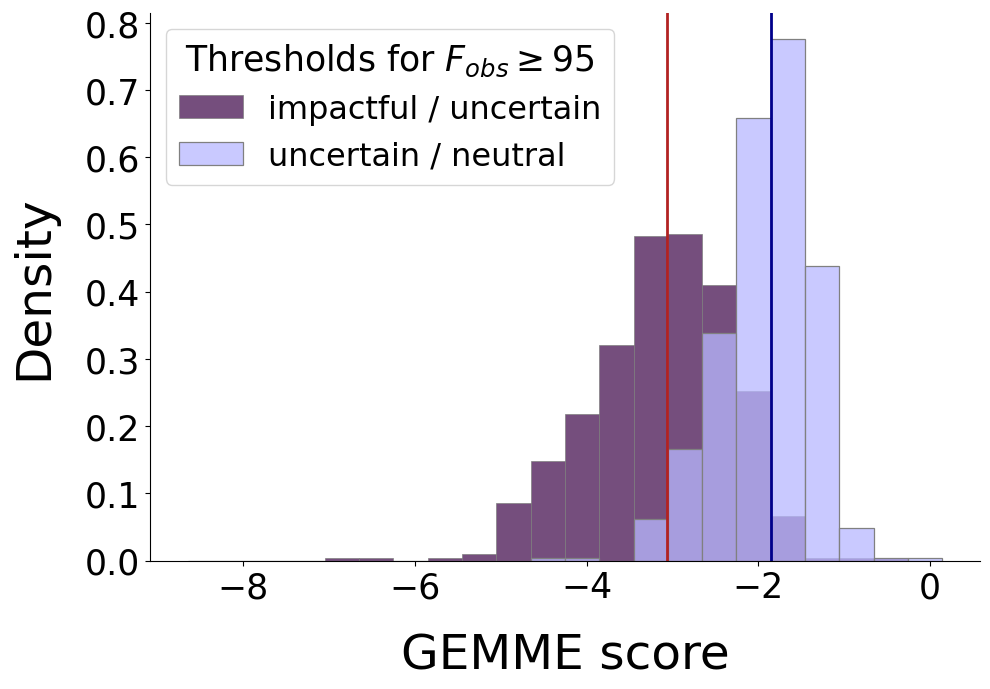

In [600]:
plt.figure(figsize=(10, 7))                      
bin_width = 0.4
# Define the range of your data
data_min = df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True), 'GMM3_impactful'].min()
data_max = df_Dmel_recap.loc[(df_Dmel_recap['Representative_FBpp']==True), 'GMM3_uncertain'].max() 
# Generate bin edges
bins_custom = np.arange(data_min, data_max + bin_width, bin_width)

# Plot the original distributions
ax = sns.histplot(df_Dmel_recap_Conf.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap_Conf['F_obs'] >= 95), 'GMM3_impactful'], bins=bins_custom, color='#53225c', alpha=0.8, edgecolor='grey', linewidth=0.5, label='impactful / uncertain', fill=True, stat='density')
ax = sns.histplot(df_Dmel_recap_Conf.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap_Conf['F_obs'] >= 95), 'GMM3_uncertain'], bins=bins_custom, color='#b8b8ff', edgecolor='grey', linewidth=0.9, label='uncertain / neutral', fill=True, stat='density')

# Calculate the medians for both distributions
median_impactful = df_Dmel_recap_Conf.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap_Conf['F_obs'] >= 95), 'GMM3_impactful'].median()
median_uncertain = df_Dmel_recap_Conf.loc[(df_Dmel_recap['Representative_FBpp']==True)&(df_Dmel_recap_Conf['F_obs'] >= 95), 'GMM3_uncertain'].median()
print(median_impactful, median_uncertain)

# Add vertical lines for the medians
plt.axvline(median_impactful, color='firebrick', linestyle='-', linewidth=2)#, label='median impactful')
plt.axvline(median_uncertain, color='darkblue', linestyle='-', linewidth=2)#, label='median uncertain')

plt.xlabel('GEMME score', fontsize=35, labelpad=20)
plt.ylabel('Density', fontsize=35, labelpad=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

legend = plt.legend(fontsize=23, loc='upper left', title=r'Thresholds for $F_{obs}\geq 95$', title_fontsize=25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/Users/manchuta/Desktop/Figures/GMM_thresholdsDistribution_Fobs95.jpg', dpi=800)
plt.show()


In [ ]:
plt.figure(figsize=(10, 7))                      
bin_width = 0.4
# Define the range of your data
data_min = df_Dmel_recap.loc[l_represen_proteoforms_Confidence, 'GMM3_impactful'].min()
data_max = df_Dmel_recap.loc[l_represen_proteoforms_Confidence, 'GMM3_uncertain'].max() 
# Generate bin edges
bins_custom = np.arange(data_min, data_max + bin_width, bin_width)

# Plot the original distributions
ax = sns.histplot(df_Dmel_recap_Conf.loc[l_represen_proteoforms_Confidence, 'GMM3_impactful'], bins=bins_custom, color='#53225c', alpha=0.8, edgecolor='grey', linewidth=0.5, label='impactful / uncertain', fill=True, stat='density')
ax = sns.histplot(df_Dmel_recap_Conf.loc[l_represen_proteoforms_Confidence,'GMM3_uncertain'], bins=bins_custom, color='#b8b8ff', edgecolor='grey', linewidth=0.9, label='uncertain / neutral', fill=True, stat='density')

# Calculate the medians for both distributions
median_impactful = df_Dmel_recap.loc[l_represen_proteoforms_Confidence, 'GMM3_impactful'].median()
median_uncertain = df_Dmel_recap.loc[l_represen_proteoforms_Confidence, 'GMM3_uncertain'].median()
print(median_impactful, median_uncertain)
# Add vertical lines for the medians
plt.axvline(median_impactful, color='firebrick', linestyle='-', linewidth=2)#, label='median impactful')
plt.axvline(median_uncertain, color='darkblue', linestyle='-', linewidth=2)#, label='median uncertain')

plt.xlabel('', fontsize=35, labelpad=20)
plt.ylabel('Density', fontsize=35, labelpad=20)
plt.xticks(fontsize=25)
plt.yticks(np.arange(0, 0.9, 0.1), fontsize=25)
plt.ylim(0, 0.8)

legend = plt.legend(fontsize=23, loc='upper left', title=r'Thresholds', title_fontsize=25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('/Users/manchuta/Desktop/Figures/GMM_thresholdsDistribution.jpg', dpi=800)
plt.show()

## PTMs

## plot pLDDT bar

In [ ]:
FBpp='FBpp0288697'
AF_pathF = df_mapping.loc[FBpp, 'Structure_3D_file']
modelPDB = gm.read_pdb(AF_pathF)[0][0]
bfactors = bfactorsPDB(modelPDB)['bfactor'].tolist()
print(bfactors)
palette_bis={0:'#FF7D45', 1:'#FFDB13', 2:'#65CBF3', 3:'#0053D6'}
bins = [0, 50, 70, 90, 100]
df = pd.DataFrame(bfactors, columns=['value'])

# Bin the values into groups
df['group'] = pd.cut(df['value'], bins=bins, labels=[0,1,2,3], right=False)
grouped_values_numeric = np.array(df['group'])

# Reshape to a one-row matrix with 395 columns
data_matrix = grouped_values_numeric.reshape(1, -1)

# Map the palette to colors for the heatmap
colors = [palette_bis[val] for val in sorted(palette_bis.keys())]
cmap = sns.color_palette(colors, len(colors))

# Plot the heatmap
plt.figure(figsize=(20, 1))  # Adjust figure size as needed
sns.heatmap(data_matrix, cmap=cmap, linewidths=0, cbar=False, xticklabels=False, yticklabels=False)

# Customize the plot
plt.savefig('/Users/manchuta/Desktop/Figures/yorkie_AFpLDDT.jpg',bbox_inches='tight',dpi=900)
# Show the plot
plt.show()

## Fig S8 pLDDT vs Local Confidence 

In [592]:
## Filter Global Confident predictions with a 3D structure
df_Confidence_Struct = df_Confidence.loc[(~df_Confidence['Num_Res_IDR'].isnull())&(df_Confidence['GEMME_GlobalConfidence']==True)].copy()

In [593]:
print(round((df_Confidence_Struct['Low_NonConf'].sum()+df_Confidence_Struct['Very_low_NonConf'].sum())/df_Confidence_Struct['Num_NonConf_Res'].sum()*100, 3), '% of non confident residues are in pLDDT < 70 regions',)
print(round((df_Confidence_Struct['Very_low'].sum()+df_Confidence_Struct['Low'].sum()-df_Confidence_Struct['Low_NonConf'].sum()-df_Confidence_Struct['Very_low_NonConf'].sum())/(df_Confidence_Struct['Very_low'].sum()+df_Confidence_Struct['Low'].sum())*100,3), '% of residues in pLDDT <70 regions have high confident predictions')

96.228 % of non confident residues are in pLDDT < 70 regions
94.219 % of residues in pLDDT <70 regions have high confident predictions


In [594]:
nb_nonconf_resi = df_Confidence_Struct['Num_NonConf_Res'].sum()
nb_all_resi = df_Confidence_Struct['Length'].sum()
nb_conf_resi = nb_all_resi - nb_nonconf_resi 
print(nb_nonconf_resi, round(nb_nonconf_resi/nb_all_resi, 4), nb_conf_resi,round(nb_conf_resi/nb_all_resi, 3), nb_all_resi)

prop_nonconf_pLDDT = (df_Confidence_Struct[['Very_low_NonConf','Low_NonConf', 'High_NonConf','Very_high_NonConf']].sum(0)/nb_nonconf_resi*100).tolist()
prop_nonconf_pLDDT = [round(x, 3) for x in prop_nonconf_pLDDT]
# Sum the specified columns
sum_all = np.array(df_Confidence_Struct[['Very_low','Low', 'High','Very_high']].sum(0))
sum_nonconf = np.array(df_Confidence_Struct[['Very_low_NonConf','Low_NonConf', 'High_NonConf','Very_high_NonConf']].sum(axis=0))
prop_conf_pLDDT = ((sum_all - sum_nonconf)/nb_conf_resi*100).tolist()
prop_conf_pLDDT = [round(x) for x in prop_conf_pLDDT]
print(prop_conf_pLDDT)


nb_IDR_resi = df_Confidence_Struct['Num_Res_IDR'].sum()
nb_IDR_resi_nonconf = df_Confidence_Struct[['Very_low_NonConf','Low_NonConf']].sum(0).sum()
nb_nonIDR_resi = nb_all_resi - nb_IDR_resi 
nb_nonIDR_resi_nonconf = df_Confidence_Struct[['High_NonConf','Very_high_NonConf']].sum(0).sum()

print(nb_IDR_resi, round(nb_IDR_resi/nb_all_resi, 4), nb_nonIDR_resi,round(nb_nonIDR_resi/nb_all_resi, 3), nb_all_resi, nb_IDR_resi_nonconf )


prop_IDR_conf = [ (nb_IDR_resi-nb_IDR_resi_nonconf)/nb_IDR_resi*100, nb_IDR_resi_nonconf/nb_IDR_resi*100]
prop_IDR_conf = [round(x, 3) for x in prop_IDR_conf]
#
#prop_IDR_nonconf = [round(x) for x in prop_IDR_nonconf]
print(prop_IDR_conf, sum(prop_IDR_conf))

prop_nonIDR_conf = [ (nb_nonIDR_resi-nb_nonIDR_resi_nonconf)/nb_nonIDR_resi*100, nb_nonIDR_resi_nonconf/nb_nonIDR_resi*100]
print(prop_nonIDR_conf, sum(prop_nonIDR_conf))


361895.0 0.0279 12588986.0 0.972 12950881
[35, 10, 25, 30]
6023625.0 0.4651 6927256.0 0.535 12950881 348245.0
[94.219, 5.781] 100.0
[99.80295228009474, 0.19704771990525538] 100.0


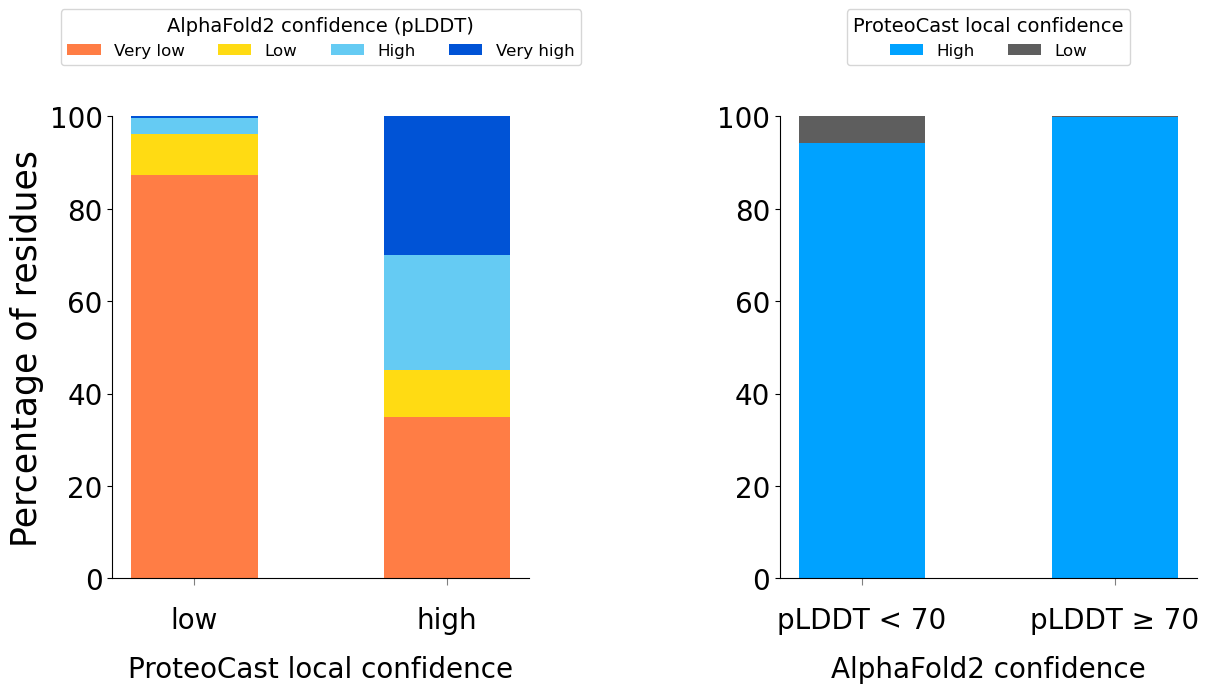

In [598]:
# Data for the first plot
bar_labels1 = ['low', 'high']
categories1 = ['Very low (pLDDT < 50)','Low (70 > pLDDT > 50)','High (90 > pLDDT > 70)', 'Very high (pLDDT > 90)']
categories1 = ['Very low','Low','High', 'Very high']

values1 = np.array([prop_nonconf_pLDDT, prop_conf_pLDDT])  # percentages for each group

# Data for the second plot
bar_labels2 = ['pLDDT < 70', 'pLDDT ≥ 70']
categories2 = ['High', 'Low']
values2 = np.array([prop_IDR_conf, prop_nonIDR_conf])  # percentages for each group

# Ensure that each bar adds up to 100%
assert np.all(values1.sum(axis=1) == 100), "Each bar must add up to 100%"
assert np.all(values2.sum(axis=1) == 100), "Each bar must add up to 100%"

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False, gridspec_kw={'wspace': 0.6})

# Plot for the first dataset
bar_width = 0.1
bar_positions1 = [0.85, 1.05]
bottom1 = np.zeros(len(bar_labels1))
colors_pLDDT1 = ['#FF7D45', '#FFDB13', '#65CBF3', '#0053D6']

for i in range(len(categories1)):
    ax1.bar(bar_positions1, values1[:, i], bar_width, bottom=bottom1, label=categories1[i], color=colors_pLDDT1[i])
    bottom1 += values1[:, i]

# Customize the first plot
ax1.set_xlabel('ProteoCast local confidence', fontsize=20, labelpad=15)
ax1.set_ylabel('Percentage of residues', fontsize=25)
ax1.set_xticks(bar_positions1)
ax1.set_xticklabels(bar_labels1, fontsize=20)
ax1.tick_params(axis='x', which='major', length=5, pad=15, color='grey')
ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax1.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)
ax1.set_ylim(0, 100)
ax1.legend(title='AlphaFold2 confidence (pLDDT)', title_fontsize=14, fontsize=12, ncol=4, loc='upper center',  bbox_to_anchor=(0.5, 1.25))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot for the second dataset
bar_positions2 = [0.85, 1.05]
bottom2 = np.zeros(len(bar_labels2))
colors_pLDDT2 = ['#00A2FF', '#5E5E5E']

for i in range(len(categories2)):
    ax2.bar(bar_positions2, values2[:, i], bar_width, bottom=bottom2, label=categories2[i], color=colors_pLDDT2[i])
    bottom2 += values2[:, i]

# Customize the second plot
ax2.set_xlabel('AlphaFold2 confidence', fontsize=20, labelpad=15)
ax2.set_xticks(bar_positions2)
ax2.set_xticklabels(bar_labels2, fontsize=20)
ax2.tick_params(axis='x', which='major', length=5, pad=15, color='grey')
ax2.set_yticks([0, 20, 40, 60, 80, 100])
ax2.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)
ax2.set_ylim(0, 100)
ax2.legend(title='ProteoCast local confidence', title_fontsize=14, fontsize=12, ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.25))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Save and show the plot
plt.savefig(f'{WORK_DIR}/Plots/Combined_pLDDT_Conf_Distrib.jpg', bbox_inches='tight', dpi=900)
plt.show()


/var/folders/v9/tv7qw0pd675c44_m3d98bz_c0000gn/T/ipykernel_1478/884574759.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)


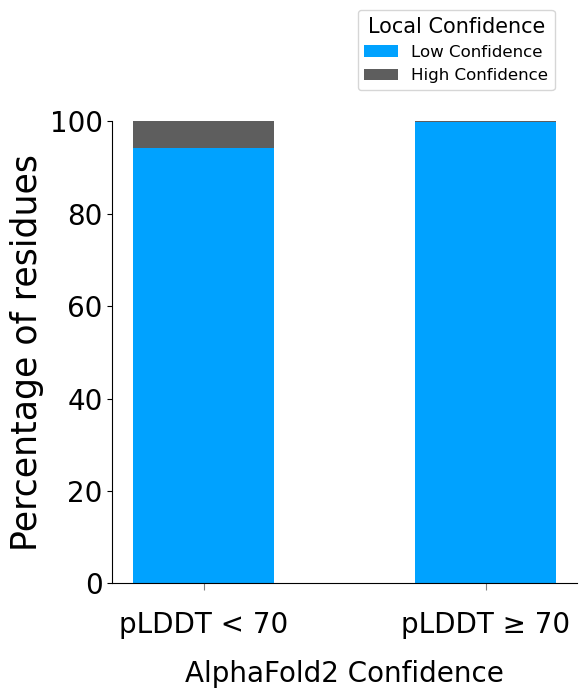

In [246]:
# Data
bar_labels = ['pLDDT < 70', 'pLDDT ≥ 70']
categories = ['Low Confidence','High Confidence']
values = np.array([prop_IDR_conf, prop_nonIDR_conf])  # percentages for each group

# Ensure that each bar adds up to 100%
assert np.all(values.sum(axis=1) == 100), "Each bar must add up to 100%"


# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Define bar positions
bar_width = 0.1
bar_positions = [0.85, 1.05]
# Plot each group segment
bottom = np.zeros(len(bar_labels))
colors_pLDDT = ['#00A2FF', '#5E5E5E']

for i in range(len(categories)):
    ax.bar(bar_positions, values[:, i], bar_width, bottom=bottom, label=categories[i], color=colors_pLDDT[i])
    bottom += values[:, i]

# Customize the plot
ax.set_xlabel('AlphaFold2 Confidence', fontsize=20, labelpad=15)
ax.set_ylabel('Percentage of residues', fontsize=25)
ax.set_xticks(bar_positions)
ax.set_xticklabels(bar_labels, fontsize=20)
ax.tick_params(axis='x', which='major', length=5, pad=15,  color='grey')
ax.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)

ax.set_ylim(0, 100)
ax.legend(title='Local Confidence', bbox_to_anchor=(0.51, 1.05), title_fontsize=15, fontsize='large')
#plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'{WORK_DIR}/Plots/ConfDistrib_bypLDDT.jpg', bbox_inches='tight', dpi=900)
# Show the plot
plt.show()

## RNAi plot

In [18]:
df_RNAiExpData = pd.read_csv('../csv/RNAi_experiments.csv')
df_RNAiExpData.sort_values('Fbgn_ID', inplace=True)

In [20]:
df_RNAiExpData_perCondition = df_RNAiExpData.groupby(['Genotype', 'Condition']).agg({
    
    'Number': 'sum',
    'CyO': 'sum', 

    'Characteristics':'first',
    'Fbgn_ID':'first', 
    'Gene_name':'first',
    'Regulation': 'first', 
    'Line':'first'
})

In [21]:
df_RNAiExpData_perGene = df_RNAiExpData.groupby(['Genotype']).agg({
    
    'Characteristics':'first',
    'Fbgn_ID':'first', 
    'Gene_name':'first',
    'Regulation': 'first', 
    'Line':'first'
})
df_RNAiExpData_perTube = df_RNAiExpData.groupby(['Genotype', 'Condition', 'Tube']).agg({
    
    'Number': 'sum',
    'CyO': 'sum', 

    'Characteristics':'first',
    'Fbgn_ID':'first', 
    'Gene_name':'first',
    'Regulation': 'first', 
    'Line':'first'
})

In [22]:
TotalRatio = df_RNAiExpData_perCondition.groupby(level=0).apply(lambda x: x.loc[x.index.get_level_values('Condition') == 'RU_20', 'Number'].values[0] / x.loc[x.index.get_level_values('Condition') == 'RU_0', 'Number'].values[0]).values
df_RNAiExpData_perGene['Ratios'] = TotalRatio
df_RNAiExpData_perGene.sort_values('Fbgn_ID', inplace=True)
df_RNAiExpData_perGene.loc[1, 'Gene_name'] = 'nAChRβ2'

In [26]:
df_RNAiExpData_perGene

,Characteristics,Fbgn_ID,Gene_name,Regulation,Line,Ratios
Genotype,,,,,,
12,None,FBgn0000212,brm,RNAi,31712,0.582202
2,Male yellow eyes,FBgn0003169,put,RNAi,27514,0.572687
14,None,FBgn0003256,rl,RNAi,31524,0.577039
10,pupa lethal,FBgn0003261,Rm62,RNAi,31395,0.197294
1,Male yellow eyes,FBgn0004118,nAChRβ2,RNAi,28038,0.578745
4,yellow eyes,FBgn0015609,CadN,RNAi,27503,0.346497
9,L3 lethal,FBgn0016983,smid,RNAi,35704,0.186813
7,None,FBgn0020412,JIL-1,RNAi,42571,0.676259
13,None,FBgn0026428,HDAC6,RNAi,31053,0.693642


In [27]:
df_RNAiExpData_perGene = df_RNAiExpData_perGene[df_RNAiExpData_perGene['Regulation']=="RNAi"]
df_RNAiExpData_perGene = df_RNAiExpData_perGene[df_RNAiExpData_perGene['Fbgn_ID']!="FBgn0037347"]
df_RNAiExpData_perGene = df_RNAiExpData_perGene[df_RNAiExpData_perGene['Fbgn_ID']!="FBgn0003256"]
df_RNAiExpData_perGene = df_RNAiExpData_perGene[df_RNAiExpData_perGene['Fbgn_ID']!="FBgn0003169"]


In [24]:
Odd_ratio_df = pd.DataFrame(index=df_RNAiExpData_perGene.index)
for genotype in df_RNAiExpData_perGene.index:
    l_ratios = []
    cpt=0
    for tube1, tube2 in it.product(range(1,6), range(1,6)):
        cpt+=1
        ratio=df_RNAiExpData_perTube.loc[(genotype, 'RU_20', tube1), 'Number']/df_RNAiExpData_perTube.loc[(genotype, 'RU_0', tube2), 'Number']
        l_ratios.append(ratio)
    Odd_ratio_df.loc[genotype, 'sum_ratio'] = np.sum(l_ratios)
    Odd_ratio_df.loc[genotype, 'mean_ratio'] = np.mean(l_ratios)
    Odd_ratio_df.loc[genotype, 'sem'] = np.std(l_ratios)/np.sqrt(10)

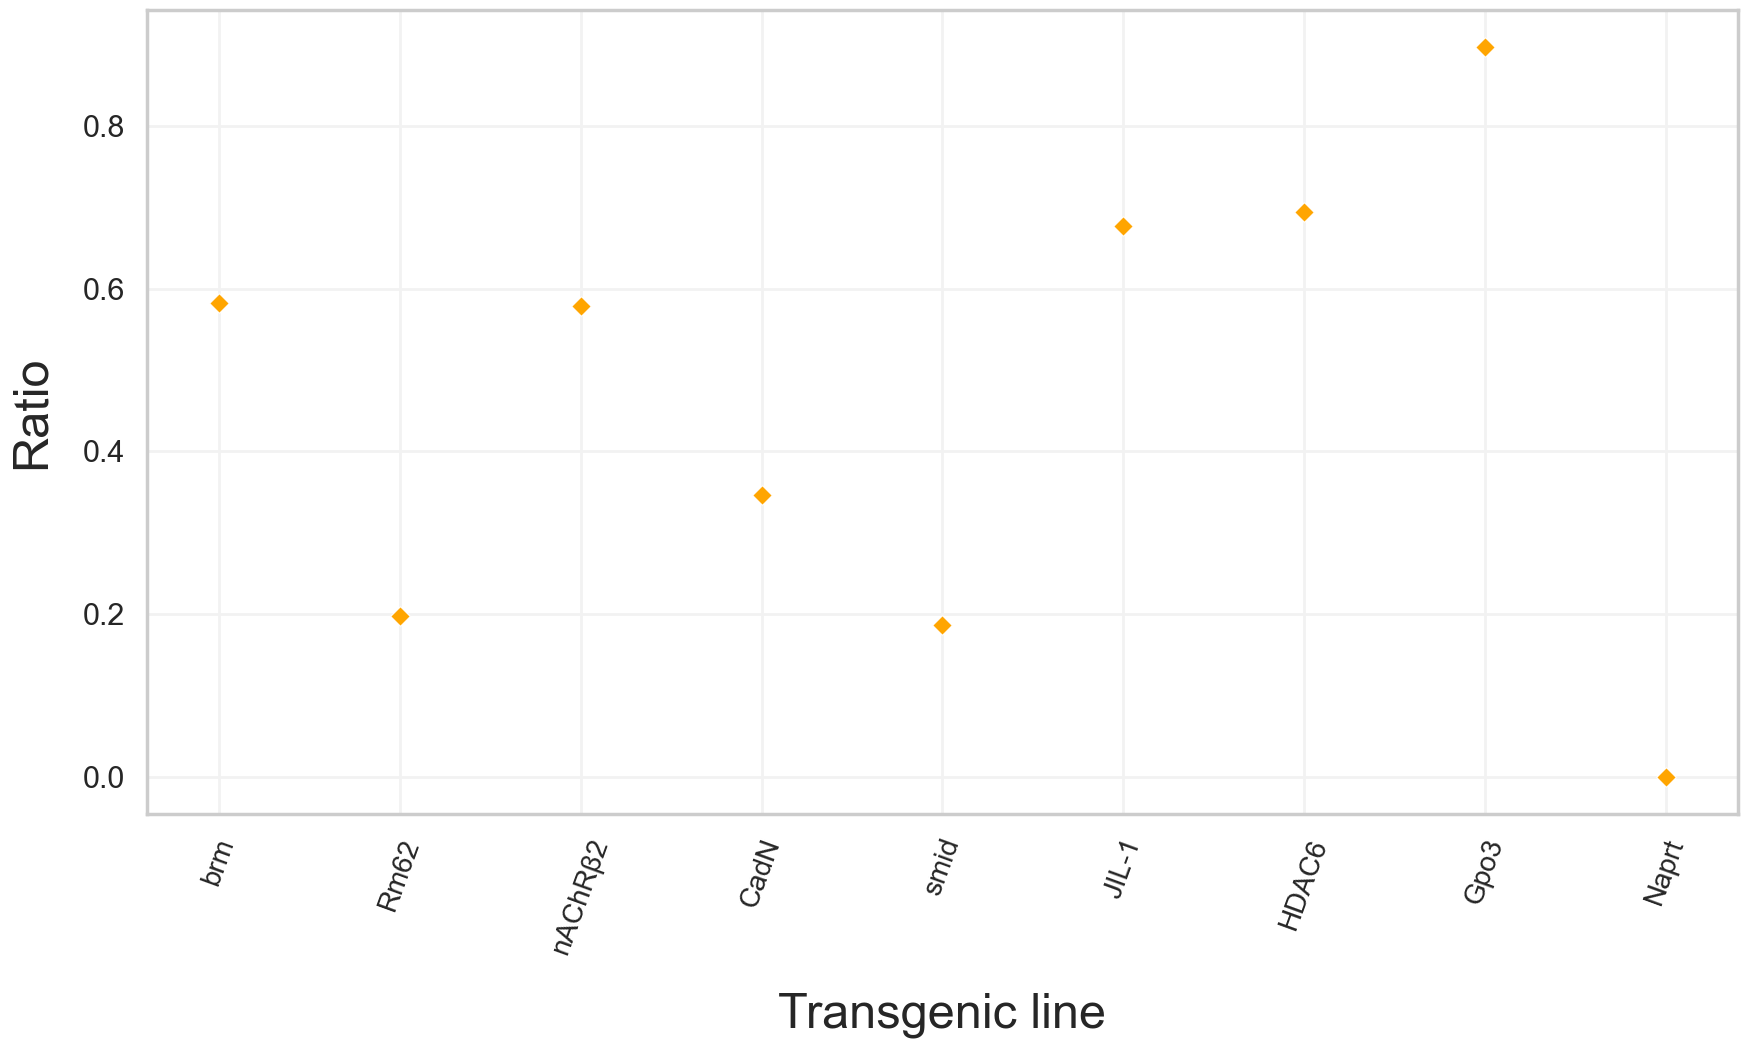

In [29]:
#x_labels = [str(row['Regulation'])+'\n'+row['Gene_name'] for index, row in df_RNAiExpData_perGene.iterrows()] 
x_labels = [row['Gene_name'] for index, row in df_RNAiExpData_perGene.iterrows()]#+' ('+str(row['Regulation']).replace('Over-expression', 'OE')+')' 
#x_labels = [str(row['Line']) +' ('+str(row['Regulation']).replace('Over-expression', 'OE')+')' for index, row in df_RNAiExpData_perGene.iterrows()]

plt.figure(figsize=(18, 11))  # Adjust the width and height as needed
# Set style and context for the plot (optional)
sns.set_style("whitegrid", {"grid.color": ".95"})
sns.set_context("poster")
# Create the plot
ax = sns.scatterplot(x=np.arange(1, len(df_RNAiExpData_perGene.index)+1), y=df_RNAiExpData_perGene['Ratios'].values, s=100, color='orange', marker='D')
plt.xlabel('Transgenic line', fontsize=35, labelpad=25)
plt.ylabel('Ratio', fontsize=35, labelpad=20)

ax.set_xticks(np.arange(1, len(df_RNAiExpData_perGene.index)+1))
ax.set_xticklabels(x_labels, fontsize=20, rotation=70)
plt.tight_layout()
plt.savefig('../Plots/RNAiExperiments.jpg', dpi=600)

plt.show()


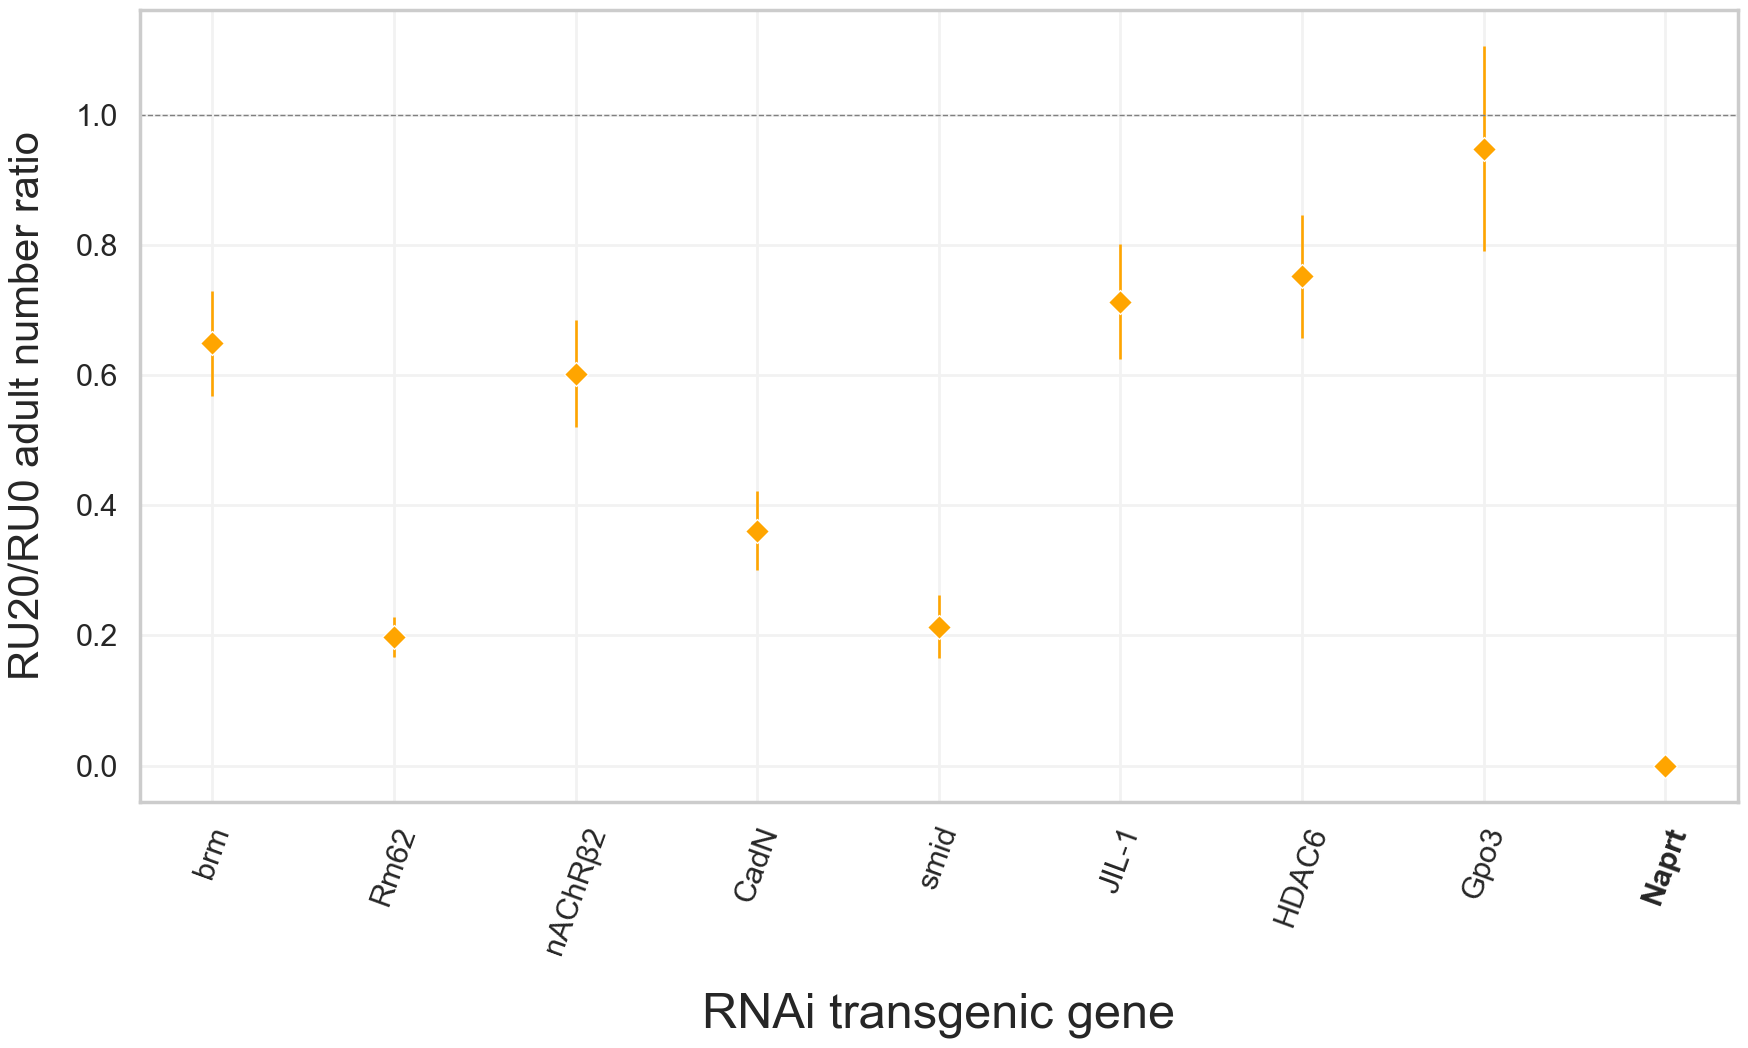

In [41]:
#x_labels = [str(row['Line']) +' ('+str(row['Regulation']).replace('Over-expression', 'OE')+')' for index, row in df_RNAiExpData_perGene.iterrows()]
x_labels = [row['Gene_name'] for index, row in df_RNAiExpData_perGene.iterrows()]

plt.figure(figsize=(18, 11))  # Adjust the width and height as needed
# Set style and context for the plot (optional)
sns.set_style("whitegrid", {"grid.color": ".95"})
sns.set_context("poster")

# Create the plot
ax = sns.scatterplot(x=np.arange(1, len(df_RNAiExpData_perGene.index)+1), y=Odd_ratio_df.loc[df_RNAiExpData_perGene.index, 'mean_ratio'], s=150,  color='orange', marker='D',zorder=2)
plt.xlabel('RNAi transgenic gene', fontsize=35, labelpad=25)
plt.ylabel('RU20/RU0 adult number ratio', fontsize=30, labelpad=20)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)

cpt=1
for genotype, row in Odd_ratio_df.loc[df_RNAiExpData_perGene.index].iterrows():
    std = Odd_ratio_df.loc[genotype, 'sem']
    mean = Odd_ratio_df.loc[genotype, 'mean_ratio']      
    plt.errorbar(cpt, mean, yerr=std, fmt='o', color='orange', markersize=0, zorder=1, capsize=0, elinewidth=1.9)
    cpt+=1


ax.set_xticks(np.arange(1, len(df_RNAiExpData_perGene.index)+1))

ax.set_xticklabels(x_labels, fontsize=22, rotation=70)
# Make only the last label bold
for label in ax.get_xticklabels():
    if label.get_text() == x_labels[-1]:  # Check if it's the last label
        label.set_fontweight('bold')
plt.tight_layout()
plt.savefig('../Plots/RNAiExperiments_OddsRatio.jpg', dpi=600)
plt.show()




## Attempt to visualize SNPs positions of DEST2 and DGRP

In [ ]:
df_Benchmark = pd.read_csv('../csv/'+'Benchmark_Evaluation_DGRP_Lethal.csv', dtype={1:str})
df_Benchmark_conf = df_Benchmark.loc[(df_Benchmark['GEMME_LocalConfidence']==True)&(df_Benchmark['GEMME_GlobalConfidence']==True)&(df_Benchmark['Set_name']!='Both')].copy()
df_Benchmark_conf_DGRP = df_Benchmark_conf.loc[(df_Benchmark_conf['Set_name']=='DGRP')].copy()
df_Benchmark_conf_DGRP['POS'] = df_Benchmark_conf_DGRP['SNP_ID'].str.split('_').str[1]
df_Benchmark_conf_DGRP['#CHROM'] = df_Benchmark_conf_DGRP['SNP_ID'].str.split('_').str[0]

for chrom in df_Benchmark_conf_DGRP['#CHROM'].unique():
    # Get coordinates of SNPs for each dataset
    l_coordDEST = df_DEST_conf.loc[df_DEST_conf['#CHROM'] == chrom, 'POS'].tolist()
    l_coordDGRP = df_Benchmark_conf_DGRP.loc[df_Benchmark_conf_DGRP['#CHROM'] == chrom, 'POS'].tolist()
    print(chrom, len(l_coordDEST), len(l_coordDGRP))

    import matplotlib.pyplot as plt

    chromosome_lengths = {
        'X': 23542271,    # ~23.5 Mb
        '2L': 23513712,   # ~23.5 Mb
        '2R': 25286936,   # ~25.3 Mb
        '3L': 28110227,   # ~28.1 Mb
        '3R': 32079331,   # ~32.1 Mb
        '4': 1348131      # ~1.35 Mb
    }
    
    # Create a figure with subplots for each chromosome
    # Loop through each chromosome
    for chrom in df_Benchmark_conf_DGRP['#CHROM'].unique():
        # Get coordinates of SNPs for each dataset
        l_coordDEST = df_DEST_conf.loc[df_DEST_conf['#CHROM'] == chrom, 'POS'].tolist()
        l_coordDGRP = df_Benchmark_conf_DGRP.loc[df_Benchmark_conf_DGRP['#CHROM'] == chrom, 'POS'].tolist()
        
        chrom_length = chromosome_lengths.get(chrom, None)
        norm_coordDEST = [int(pos) / chrom_length for pos in l_coordDEST]
        norm_coordDGRP = [int(pos) / chrom_length for pos in l_coordDGRP]
    
        print(norm_coordDEST)
        # Create the figure
        plt.figure(figsize=(10, 2))
        
        # Plot SNP positions for DEST
        plt.scatter(norm_coordDEST, [1] * len(l_coordDEST), label='DEST', alpha=0.7, marker='|', color='blue')
         
        # Plot SNP positions for DGRP
        plt.scatter(norm_coordDGRP, [2] * len(l_coordDGRP), label='DGRP', alpha=0.7, marker='|', color='red')
        sns.scatterplot 
        plt.xlim(-0.1, 1.1)
        # Add labels and title
        plt.title(f'SNP Positions on Chromosome {chrom}')
        plt.xlabel('Chromosome Position (bp)')
        plt.yticks([1, 2], ['DEST', 'DGRP'])
        plt.legend(loc='center right')
        plt.tight_layout()
        plt.savefig(f'../Plots/Chrom_{chrom}_SNP_Positions.png', dpi=500)
        # Show the plot
        plt.show()
        plt.close()

## GMM plot

In [128]:
def plotGMM(GMM_model, df_thresh, df_proteocast, l_mut=[], SNPscores=[], SNPset = [], path=None):
    
    '''plot GMM distribution for a given protein and its mutations'''
    #sns.set(style="ticks")
    #sns.set_context("notebook")
   
    # Extract GEMME raw values from Single_mut DataFrame
    values = np.array(df_proteocast['GEMME_score'])

    # Calculate component shares (probabilities) using GMM for the given data values
    component_share = GMM_model.predict_proba(values.reshape(-1, 1))  # Shape: (#values, #clusters)
    # Get the cluster means and sort the indices
    cluster_means = GMM_model.means_.flatten(); sorted_indices = np.argsort(cluster_means)
    cluster_means = cluster_means[sorted_indices]; stdD = np.sqrt(np.array(GMM_model.covariances_).flatten()[sorted_indices])
    # Reorder component_share based on sorted indices and add the values column
    component_shareOrdered = component_share[:, sorted_indices]
    component_shareOrdered = np.hstack((values.reshape(-1, 1), component_shareOrdered))
    bin_width = 0.25
    # Determine the desired bin width
    # Calculate the number of bins dynamically based on the data range and desired bin width
    data_range = np.max(values) - np.min(values)
    num_bins = int(np.ceil(data_range / bin_width))
    bin_edges = np.linspace(np.min(values), np.max(values), num_bins + 1)
    nx_pmf, xbins = np.histogram(values, bins=bin_edges,density=False)
    nx_pmf = nx_pmf/len(df_proteocast)
    widthBar = xbins[1] - xbins[0]

    fig, ax = plt.subplots(figsize=(8, 5)) ##18, 14
    plt.bar(xbins[:-1], nx_pmf, width=widthBar, align='edge', color='xkcd:grey',edgecolor='white', alpha=0.5, label='GEMME scores')
    #plt.hist(Single_mut, color='xkcd:grey', bins=bin_edges, histtype='stepfilled', alpha=0.5, density=True)#density= True
    # Adjust the last bin edge
    xbins[-1] = xbins[-1] + 0.00001
    # Define colors and width for bars
    widthBar = xbins[1] - xbins[0]
    # Define colors and width for bars
    set_colors = ['xkcd:purple', 'xkcd:green', 'xkcd:grey']                                             ## colors for 3,4,5 GMM clusters
    # Get colors for the clusters (skip the first and last colors)
    cluster_colors = ['xkcd:red']+[set_colors[i] for i in range(len(cluster_means- 1)-2)]+['xkcd:blue']
    clusters_height = pd.DataFrame({'xbins':xbins[:-1]})
    # Plot histograms for each cluster
    for cluster, color in zip(range(1, component_shareOrdered.shape[1]),cluster_colors):  # Iterate over clusters, not probabilities
        # Calculate heights for the bars
        l_height =[np.mean(component_shareOrdered[(component_shareOrdered[:, 0] >= xbins[i-1]) &
                                                    (component_shareOrdered[:, 0] < xbins[i]), cluster])
                    for i in range(1, len(xbins))] * nx_pmf
        clusters_height[cluster-1]=l_height
        # Plot the bars uncomment if want to plot
        label_custom=r"$\mu={:.2f} \ ; \ \sigma={:.2f}$".format(cluster_means[cluster-1],stdD[cluster-1])
        plt.bar(xbins[:-1], l_height, color=color, alpha=0.27, label=label_custom,edgecolor='white',  width=widthBar, align='edge')
        # Iterate over mutations and add dots and annotations
        if SNPscores: 
            sorted_mut = np.argsort(SNPscores)
            dc_colors = {1:'r', 0.5:'m', 0:'b'}
            dc_colors_set = {'Lethal':'r', 'DGRP':'b', 'DEST2':'b', 'DGRP+DEST2':'b', 'DEST2+DGRP':'b'}

            for i in range(len(l_mut)):
                #color = dc_colors[SNPclasses[sorted_mut[i]]]
                color = dc_colors_set[SNPset[sorted_mut[i]]]
 
                if SNPscores[sorted_mut[i]]<np.min(values)/2:
                    y = max(nx_pmf)/2- 0.003*i
                else:
                    y = max(nx_pmf)- 0.003*i 
                #if l_mut[sorted_mut[i]]=='P184S':
                #    y = max(nx_pmf)- 0.01
                y_line = np.arange(0, y, 0.001)
                # Plot dots and lines for mutations
            
                marker_shapes = {'Lethal': 'o', 'DGRP': 's', 'DEST2': '^', 'DEST2+DGRP': 'D', 'DGRP+DEST2': 'D'}
                plt.plot(SNPscores[sorted_mut[i]], y, marker=marker_shapes[SNPset[sorted_mut[i]]], color=color, linestyle='--', alpha=0.5, markersize=6, markeredgewidth=1)
                plt.plot([SNPscores[sorted_mut[i]]] * len(y_line), y_line, 'k:', alpha=0.3, linewidth=1.9, zorder=2)
                # Annotate mutations
                plt.annotate(f'{l_mut[sorted_mut[i]]}', (SNPscores[sorted_mut[i]] + 0.045, y), fontsize=13, color='black',alpha=0.55, weight='normal',
                                rotation=30, zorder=2)#dimgrey





    plt.axvline(x=df_thresh.loc['GMM3_impactful'].item(), color='#6f0043', linestyle='-', linewidth=3.5, zorder=1) #label = ' = - 2.25',
    plt.axvline(x=df_thresh.loc['GMM3_uncertain'].item(), color='#ffcfc4', linestyle='-', linewidth=3.5, zorder=1) #label = ' threshold = - 3.48',
    #plt.xlim(-10, 0)
    # Hide all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.ylabel('Density', fontsize=18, labelpad=10)
    plt.xlabel('GEMME score', fontsize=18, labelpad=10)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ## alternative
    #ax.tick_params(axis='x',pad=10)
    plt.tight_layout()
    if path:
        plt.savefig(path, dpi=500, format='jpg')
    plt.clf()
    plt.close()

In [125]:
## change this part if the backgroud GMM distribution and thresholds should be different
FBpp = 'FBpp0071381'
id = df_mapping.loc[FBpp, 'id']
df_proteocast = pd.read_csv(f'{WORK_DIR}/Drosophila_ProteoCast/{id}/4.{FBpp}_ProteoCast.csv', index_col=0)

df_thresh = df_Dmel_recap.loc[FBpp].copy()

with open(f'{WORK_DIR}/GMM3_Confidence/{FBpp}_GMM_model.pickle', 'rb') as f:
    GMM_model = pickle.load(f)


FBpp = 'FBpp0071381'
id = df_mapping.loc[FBpp, 'id']
df_snps = pd.read_csv(f'{WORK_DIR}/Drosophila_ProteoCast/{id}/7.{FBpp}_SNPs.csv')
df_snps = df_snps.loc[df_snps['Set_name']!='Hypomorphic']

df_snps = df_snps.groupby(['Mutation', 'Residue']).agg({
    'GEMME_score': 'first',
    'Set_name': lambda x: '+'.join(sorted(set(x)))
}).reset_index()

#df_snps.drop_duplicates(subset=['Mutation', 'Residue'], keep='first', inplace=True)
plotGMM(GMM_model,df_thresh, df_proteocast, df_snps['Mutation'].tolist(), df_snps['GEMME_score'].tolist(),df_snps['Set_name'].tolist(), f'{WORK_DIR}/Plots/{FBpp}_GMM_FigS13.jpg')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.1.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## GMM droso plots

In [391]:
def plotGMM(GMM_model, df_thresh, df_proteocast, l_mut=[], SNPscores=[], SNPset = [], path=None):
   
    '''plot GMM distribution for a given protein and its mutations'''
    #sns.set(style="ticks")
    #sns.set_context("notebook")
   
    # Extract GEMME raw values from Single_mut DataFrame
    values = np.array(df_proteocast['GEMME_score'])

    # Calculate component shares (probabilities) using GMM for the given data values
    component_share = GMM_model.predict_proba(values.reshape(-1, 1))  # Shape: (#values, #clusters)
    # Get the cluster means and sort the indices
    cluster_means = GMM_model.means_.flatten(); sorted_indices = np.argsort(cluster_means)
    cluster_means = cluster_means[sorted_indices]; stdD = np.sqrt(np.array(GMM_model.covariances_).flatten()[sorted_indices])
    # Reorder component_share based on sorted indices and add the values column
    component_shareOrdered = component_share[:, sorted_indices]
    component_shareOrdered = np.hstack((values.reshape(-1, 1), component_shareOrdered))
    bin_width = 0.25
    # Determine the desired bin width
    # Calculate the number of bins dynamically based on the data range and desired bin width
    data_range = np.max(values) - np.min(values)
    num_bins = int(np.ceil(data_range / bin_width))
    bin_edges = np.linspace(np.min(values), np.max(values), num_bins + 1)
    nx_pmf, xbins = np.histogram(values, bins=bin_edges,density=False)
    nx_pmf = nx_pmf/len(df_proteocast)
    widthBar = xbins[1] - xbins[0]

    fig, ax = plt.subplots(figsize=(8, 5)) ##18, 14
    plt.bar(xbins[:-1], nx_pmf, width=widthBar, align='edge', color='xkcd:grey',edgecolor='white', alpha=0.5, label='GEMME scores')
    #plt.hist(Single_mut, color='xkcd:grey', bins=bin_edges, histtype='stepfilled', alpha=0.5, density=True)#density= True
    # Adjust the last bin edge
    xbins[-1] = xbins[-1] + 0.00001
    # Define colors and width for bars
    widthBar = xbins[1] - xbins[0]
    # Define colors and width for bars
    set_colors = ['xkcd:purple', 'xkcd:green', 'xkcd:grey']                                             ## colors for 3,4,5 GMM clusters
    # Get colors for the clusters (skip the first and last colors)
    cluster_colors = ['xkcd:red']+[set_colors[i] for i in range(len(cluster_means- 1)-2)]+['xkcd:blue']
    clusters_height = pd.DataFrame({'xbins':xbins[:-1]})

    dc_colors_set = {'Lethal':'r', 'DGRP':'b', 'DEST2':'b', 'DGRP+DEST2':'b', 'DEST2+DGRP':'b'}
    marker_shapes = {'Lethal': 'o', 'DGRP': 's', 'DEST2': '^', 'DEST2+DGRP': 'X', 'DGRP+DEST2': 'X'}
    # Plot histograms for each cluster
    for cluster, color in zip(range(1, component_shareOrdered.shape[1]),cluster_colors):  # Iterate over clusters, not probabilities
        # Calculate heights for the bars
        l_height =[np.mean(component_shareOrdered[(component_shareOrdered[:, 0] >= xbins[i-1]) &
                                                    (component_shareOrdered[:, 0] < xbins[i]), cluster])
                    for i in range(1, len(xbins))] * nx_pmf
        clusters_height[cluster-1]=l_height
        # Plot the bars uncomment if want to plot
        label_custom=r"$\mu={:.2f} \ ; \ \sigma={:.2f}$".format(cluster_means[cluster-1],stdD[cluster-1])
        plt.bar(xbins[:-1], l_height, color=color, alpha=0.27, label=label_custom,edgecolor='white',  width=widthBar, align='edge')
        
        # Iterate over mutations and add dots and annotations
        if SNPscores:
            sorted_mut = np.argsort(SNPscores)
            
            cpt=0; flag=True
            for i in range(len(l_mut)):
                #color = dc_colors[SNPclasses[sorted_mut[i]]]
                color = dc_colors_set[SNPset[sorted_mut[i]]]
                x_pos = SNPscores[sorted_mut[i]]
        
                if  x_pos < np.min(values) / 2:
                    y = max(nx_pmf) / 2 - 0.005 * i
                elif x_pos > np.min(values) / 4:
                    if (x_pos>-1) and flag:
                        cpt=0;flag=False
                    y = max(nx_pmf) - 0.005 * cpt
                    
                    cpt += 1
                else:
                    y = max(nx_pmf) - 0.005 * i

                y_line = np.arange(0, y, 0.001)
                # Plot dots and lines for mutations
           
                plt.plot(x_pos, y, marker=marker_shapes[SNPset[sorted_mut[i]]], color=color, zorder=3, alpha=0.5, markersize=5.5, markeredgewidth=1)
                plt.plot([x_pos] * len(y_line), y_line, 'k:', alpha=0.2, linewidth=1.5, zorder=2)
                # Annotate mutations
                plt.annotate(f'{l_mut[sorted_mut[i]]}', (x_pos + 0.045, y), fontsize=11, color='black', alpha=0.65, weight='normal',
                             rotation=45, zorder=4, bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.4))


    plt.axvline(x=df_thresh.loc['GMM_impactful'].item(), color='#6f0043', linestyle='-', linewidth=3.5, zorder=1) #label = ' = - 2.25',
    plt.axvline(x=df_thresh.loc['GMM_uncertain'].item(), color='#ffcfc4', linestyle='-', linewidth=3.5, zorder=1) #label = ' threshold = - 3.48',

    # Hide all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.ylabel('Density', fontsize=18, labelpad=10)
    plt.xlabel('GEMME score', fontsize=18, labelpad=10)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ## alternative
    #ax.tick_params(axis='x',pad=10)
    plt.tight_layout()
    if path:
        plt.savefig(path, dpi=500, format='jpg')
    plt.clf()
    plt.close()

In [396]:
proteocast='../Drosophila_ProteoCast/8898/4.FBpp0087109_ProteoCast.csv'
df_proteocast = pd.read_csv(proteocast, index_col=0)

protein = proteocast.split('/')[-1].split('_')[0].split('.')[1]
id = int(proteocast.split('/')[-2])

df_thresh = pd.read_csv(f'../Drosophila_ProteoCast/{id}/{protein}_GMMthresholds.csv', index_col=0)

with open(f'../GMM3_Confidence/{protein}_GMM_model.pickle', 'rb') as f:
    GMM_model = pickle.load(f)

if os.path.exists(f'../Drosophila_ProteoCast/{id}/7.{protein}_SNPs.csv'):

    df_snps = pd.read_csv(f'../Drosophila_ProteoCast/{id}/7.{protein}_SNPs.csv')
    df_snps = df_snps.loc[df_snps['Set_name'] != 'Hypomorphic'] 
    df_snps = df_snps.groupby(['Mutation', 'Residue']).agg({
            'GEMME_score': 'first',
            'Set_name': lambda x: '+'.join(sorted(set(x)))
        }).reset_index()
    df_snps = df_snps.loc[df_snps['Set_name'].isin(['Lethal', 'DGRP', 'DEST2','DGRP+DEST2', 'DEST2+DGRP'])]

    # Keep all Lethal mutations
    df_snps_lethal = df_snps[df_snps['Set_name'] == 'Lethal']
    # Take up to 15 DEST2+DGRP mutations
    df_snps_dest2_dgrp = df_snps[df_snps['Set_name'] == 'DEST2+DGRP'].head(15)

    # Calculate remaining space
    remaining_space = 20 - len(df_snps_dest2_dgrp)
    if remaining_space < 0:
        remaining_space = 0
    # Take remaining DEST2 mutations if space allows
    df_snps_dest2 = df_snps[df_snps['Set_name'] == 'DEST2'].head(remaining_space)

    # Update remaining space
    remaining_space -= len(df_snps_dest2)
    if remaining_space < 0:
        remaining_space = 0
    # Take remaining DGRP mutations if space allows
    df_snps_dgrp = df_snps[df_snps['Set_name'] == 'DGRP'].head(remaining_space)

    # Concatenate all selected mutations
    df_snps = pd.concat([df_snps_lethal, df_snps_dest2_dgrp, df_snps_dest2, df_snps_dgrp])


        #df_snps.drop_duplicates(subset=['Mutation', 'Residue'], keep='first', inplace=True)
plotGMM(GMM_model,df_thresh, df_proteocast, df_snps['Mutation'].tolist(), df_snps['GEMME_score'].tolist(),df_snps['Set_name'].tolist(), f'{WORK_DIR}/Plots/{FBpp}_GMM_FigS2.jpg')